<center>

# **PROJEKT**
## Klasifikacija slika tumora mozga <br> Sunčica Prgomet
<br>



</center>

# **Učitavanje i priprema podataka**



### Učitavanje podataka

In [132]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [133]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [134]:
%cd /content/drive/MyDrive/data

/content/drive/MyDrive/data


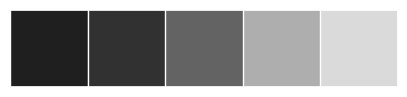

In [135]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
sns.palplot(colors_dark) #prikaz palate 5 razlicitih boja

Imamo 4 klase

In [136]:
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']

Uzela samo dio podataka (svaki 2.) radi lakšeg učitavanja

Ovaj kod učitava slike iz određenih mapa (directories) na temelju zadane putanje (base_path) i određenih oznaka (labels)

In [137]:
#nismo uzeli sve podatke, samo dio
import os
import cv2
import numpy as np
from tqdm import tqdm

X = []
y = []
image_size = 150

def load_images_from_folder(folder_path, label):
    images = []
    for idx, file_name in enumerate(os.listdir(folder_path)):
        if idx % 2 == 0:  # Uzimaj samo slike s parnim indeksom   ili uzimaj sve slike ovisno 1 ili 2 tu
            img = cv2.imread(os.path.join(folder_path, file_name))
            img = cv2.resize(img, (image_size, image_size))
            X.append(img)
            y.append(label)

# Promijenite putanju prema vašim podacima
base_path = '/content/drive/MyDrive/data'

for label in labels:
    training_folder_path = os.path.join(base_path, 'Training', label)
    load_images_from_folder(training_folder_path, label)

for label in labels:
    testing_folder_path = os.path.join(base_path, 'Testing', label)
    load_images_from_folder(testing_folder_path, label)

X = np.array(X)
y = np.array(y)


Prikažimo po 1 podatak iz svake klase

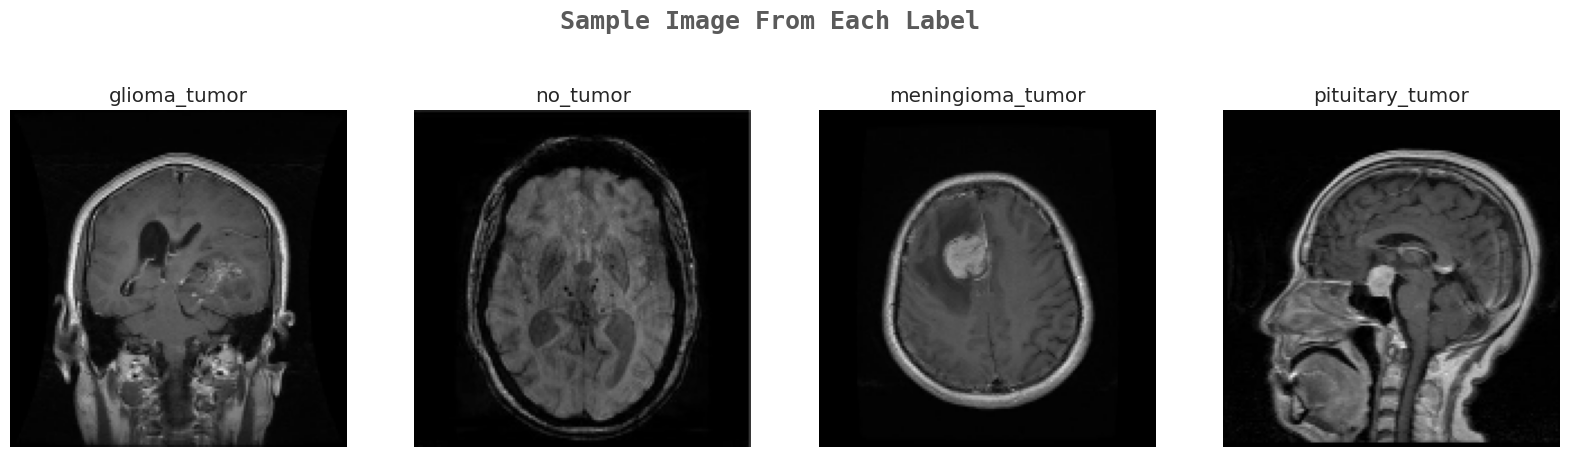

In [138]:
k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.62,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True :
        if y[j]==i:
            ax[k].imshow(X[j])
            ax[k].set_title(y[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

 Imamo 1634 slike, svaka dimenzija slike je 150x150 piksela, i svaka slika ima tri boje (RGB).

 (visina,širina,kanali boje)

 Svaka slika je 3-dimenzionalna matrica, ima 150 redaka, 150 stupaca i 3 dubine

In [139]:
X.shape

(1634, 150, 150, 3)

In [140]:
X[0].shape

(150, 150, 3)

###Skaliranje podataka



Razlozi skaliranja:<br>
 1.Stabilnost algoritma optimizacije: Mnogi algoritmi optimizacije, posebice oni koji se temelje na gradijentnom spustu, brže konvergiraju kada su značajke skalirane na sličan raspon <br>
 2.Izbjegavanje numeričkih problema: Skaliranje pomaže u izbjegavanju numeričkih problema, poput overflow-a ili underflow-a <br>
 3.Regularizacija: Mnogi modeli, poput linearnih regresija i SVM-ova, uključuju regularizaciju. Skalirane značajke osiguravaju da svi koeficijenti doprinose jednako regularizaciji, čime se održava balans u pridonošenju svake značajke modelu <br>
 4.Jednostavnost interpretacije modela:kod klasifikacije, odlučujuće granice će biti bolje usklađene

Min-Max skaliranje ručno:

In [141]:
# Ispis minimalne i maksimalne vrijednosti prije skaliranja
print("Min vrijednost prije skaliranja:", np.min(X))
print("Max vrijednost prije skaliranja:", np.max(X))

Min vrijednost prije skaliranja: 0
Max vrijednost prije skaliranja: 255


In [142]:
X=X/255.0

# Ispis minimalne i maksimalne vrednosti nakon skaliranja
print("Min vrijednost nakon skaliranja:", np.min(X))
print("Max vrijednost nakon skaliranja:", np.max(X))

Min vrijednost nakon skaliranja: 0.0
Max vrijednost nakon skaliranja: 1.0


###Podjela podataka na train i test

In [143]:
from sklearn.model_selection import train_test_split

# Podijela podataka X i y na train i test skupove
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) #random state 42 = svaki put kada ponovno pokrenemo kod podjela podataka će biti ista

# Ispisivanje oblika rezultirajućih skupova
print("Oblik X_train:", X_train.shape)
print("Oblik X_test:", X_test.shape)
print("Oblik y_train:", y_train.shape)
print("Oblik y_test:", y_test.shape)


Oblik X_train: (1307, 150, 150, 3)
Oblik X_test: (327, 150, 150, 3)
Oblik y_train: (1307,)
Oblik y_test: (327,)


###Uklanjanje pristranosti

**Provjera balansiranosti podataka**

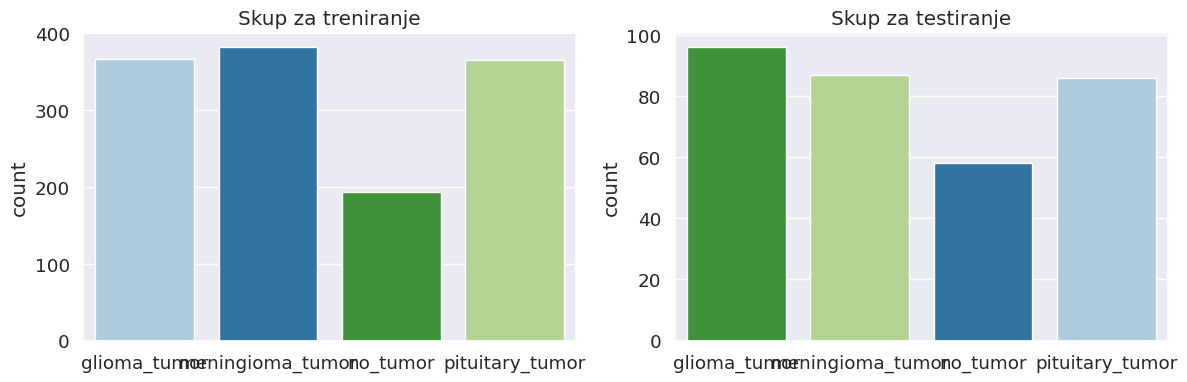

In [144]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def vizualiziraj_balans_klasa(y_train, y_test):
    train_sentiments, train_counts = np.unique(y_train, return_counts=True)
    test_sentiments, test_counts = np.unique(y_test, return_counts=True)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

    ax = sns.countplot(x=y_train,
                       order=train_sentiments,
                       hue=y_train,  # Assigning hue to x variable
                       ax=ax1,
                       palette='Paired',
                       legend=False  # Set legend to False
                       ).set(title='Skup za treniranje')

    ax = sns.countplot(x=y_test,
                       order=test_sentiments,
                       hue=y_test,  # Assigning hue to x variable
                       ax=ax2,
                       palette='Paired',
                       legend=False  # Set legend to False
                       ).set(title='Skup za testiranje')

    plt.show()

# Poziv funkcije s oznakama klasa
vizualiziraj_balans_klasa(y_train, y_test)


**Uklanjanje pristranosti**

Da bi se izbjegla pristranost prema većim klasama jer to može dovesti do loše generalizacije.

Koristimo oversampler tj dupliranje podataka manjinskih klasa.

Dupliramo postojeće podatke pa time ne mijenjamo distribuciju uzorka.

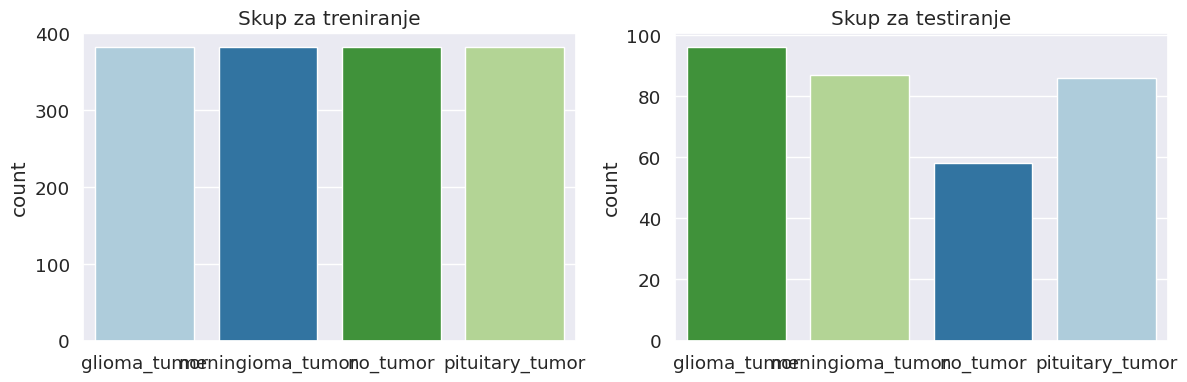

In [145]:
from imblearn.over_sampling import RandomOverSampler
def izjednaci_klase(X_train, y_train):
    # Prvo, izjednačimo broj uzoraka u svakoj klasi oversamplingom
    sampler = RandomOverSampler(random_state=42)
    X_resampled, y_resampled = sampler.fit_resample(X_train.reshape(X_train.shape[0], -1), y_train)
    return X_resampled.reshape(-1, *X_train.shape[1:]), y_resampled

# Poziv funkcije za izjednačavanje klasa
X_train, y_train = izjednaci_klase(X_train, y_train)

# Provjerite ponovno balansiranje klasa
vizualiziraj_balans_klasa(y_train, y_test)


###Ravnanje podataka

**Ravnamo podatke tj preoblikujemo slike u 1-dimenzionalne vektore**

Pretvara trodimenzionalnu matricu u jednodimenzionalni vektor tako da raspakira sve elemente matrice u jedan niz

In [ ]:
X_train_izravnan=X_train.reshape(X_train.shape[0],-1) #-1 znaci da ce NumPy automatski izracunati potrebnu duljinu te dimenzije kako bi se ocuvao isti ukupan broj elemenata

In [ ]:
X_test_izravnan=X_test.reshape(X_test.shape[0],-1)

In [ ]:
X_izravnan=X.reshape(X.shape[0],-1)

###Kodiranje varijable koju predviđamo

**Kodiranje zavisne varijable y**

In [ ]:
y_train.shape

(1528,)

In [ ]:
y_train.reshape(-1,1).shape

(1528, 1)

Encoder očekuj 2-dim ulaz zato reshape (niz 1 dim nizova)

In [ ]:
y_train_2d=y_train.reshape(-1,1)
y_test_2d=y_test.reshape(-1,1)

**OneHotEncoder**

Kako bismo osigurali da iste klase imaju iste one-hot vektore u oba skupa podataka, moramo koristiti isti OneHotEncoder za oba skupa.

In [ ]:
from sklearn.preprocessing import OneHotEncoder

# Inicijalizacija OneHotEncoder-a s parametrom handle_unknown='ignore'
encoder = OneHotEncoder(handle_unknown='ignore')

# Spajanje trening i test podataka
y_combined = np.concatenate((y_train_2d, y_test_2d), axis=0)

# Fitiranje OneHotEncoder-a na kombiniranom skupu podataka
encoder.fit(y_combined)

# Transformacija trening i test skupa
y_train_onehot = encoder.transform(y_train_2d).toarray()
y_test_onehot = encoder.transform(y_test_2d).toarray()

Sada su nam klase označene ovako:

In [ ]:
# Dobivanje jedinstvenih imena klasa
unique_classes = np.unique(np.concatenate((y_train, y_test)))

# Ispisivanje originalnih imena klasa i pripadajućih one-hot vektora za svaku klasu
print("Originalne klase i odgovarajući one-hot vektori:")
for class_name in unique_classes:
    train_vector = y_train_onehot[np.where(y_train == class_name)[0][0]]  # Pronalazak odgovarajućeg one-hot vektora u trening skupu
    test_vector = y_test_onehot[np.where(y_test == class_name)[0][0]]     # Pronalazak odgovarajućeg one-hot vektora u test skupu
    print(f"{class_name} : {train_vector if class_name in y_train else 'N/A (nije prisutno u trening skupu)'} (trening), {test_vector if class_name in y_test else 'N/A (nije prisutno u test skupu)'} (test)")

Originalne klase i odgovarajući one-hot vektori:
glioma_tumor : [1. 0. 0. 0.] (trening), [1. 0. 0. 0.] (test)
meningioma_tumor : [0. 1. 0. 0.] (trening), [0. 1. 0. 0.] (test)
no_tumor : [0. 0. 1. 0.] (trening), [0. 0. 1. 0.] (test)
pituitary_tumor : [0. 0. 0. 1.] (trening), [0. 0. 0. 1.] (test)


**Numeričko kodiranje**

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Inicijalizacija i fitiranje LabelEncoder-a
label_encoder = LabelEncoder()
label_encoder.fit(np.concatenate((y_train, y_test), axis=0))

# Transformacija trening i test skupa
y_train_num = label_encoder.transform(y_train)
y_test_num = label_encoder.transform(y_test)

Sada su nam klase označene ovako:

In [ ]:
# Ispisivanje originalnih imena klasa i pripadajućih numeričkih kodova za svaku klasu
print("Originalne klase i odgovarajući numerički kodovi:")
for class_name in unique_classes:
    train_code = label_encoder.transform([class_name])[0] if class_name in y_train else 'N/A (nije prisutno u trening skupu)'
    test_code = label_encoder.transform([class_name])[0] if class_name in y_test else 'N/A (nije prisutno u test skupu)'
    print(f"{class_name} : {train_code} (trening), {test_code} (test)")

Originalne klase i odgovarajući numerički kodovi:
glioma_tumor : 0 (trening), 0 (test)
meningioma_tumor : 1 (trening), 1 (test)
no_tumor : 2 (trening), 2 (test)
pituitary_tumor : 3 (trening), 3 (test)


#**Smanjenje dimenzionalnosti PCA i TSNE**

**Smanjenje dimenzionalnosti** (engl. *dimensionality reduction*) je postupak transformacije podataka kojim se na smislen način smanjuje broj značajki (dimenzija) u danom skupu podataka.

> Drugim riječima, podatke se na određen način preslikava iz jednog prostora dimenzije $D$ u drugi prostor manje dimenzije $d < D$.

Zašto želimo smanjiti dimenzionalnost prostora?

1. **Uklanjenje višestrukih značajki**: uklanjanje redundancije u danim podacima, uklanjanje međusobno povezanih i linearno zavisnih značajki.

2. **Ublažavanje problema prokletstva dimenzionalnosti**: U visokodimenzionalnim prostorima češće se javljaju problemi poput prenaučenosti modela. Smanjenjem dimenzionalnosti može se smanjiti složenost modela i poboljšati njegova generalizacija.

3. **Povećanje učinkovitosti algoritama**: *ubrzava se proces učenja* algoritama strojnog učenja, *smanjuje se zahtjev za resursima* i *poboljšavaju se performanse modela*.

4. **Vizualizacija podataka**: teško je vizualizirati visokodimenzionalne podatke.

Koristit ćemo algoritme koji provode ekstrakciju značajki.


### TSNE (t-distributed stochastic neighbor embedding)



Korsiti se uglavnom za vizualizacijske svrhe.

**OSNOVNA OBILJEŽJA:**

- **nelinearna** tehnika smanjenja dimenzionalnosti prostora
- fokusira se na **očuvanje relativnih susjedstava između instanci** u visokodimenzionalnom prostoru ➡ slične instance u originalnom prostoru značajki imaju tendenciju biti "blizu" i u niskodimenzionalnom prostoru
- koristi **t-distribuirane vjerojatnosti** kako bi mjerio sličnosti između parova instanci u originalnom i smanjenom prostoru
- nije uvijek optimalan za očuvanje globalne strukture podataka, pa se preporučuje oprezna interpretacija vizualizacija dobivenih ovom tehnikom
- **može biti spor** za velike skupove podataka, posebno u usporedbi s PCA.

In [ ]:
X_izravnan.shape

(1634, 67500)

67500-dimenzionalne podatke transformiramo u 2-dimenzionalne podatke

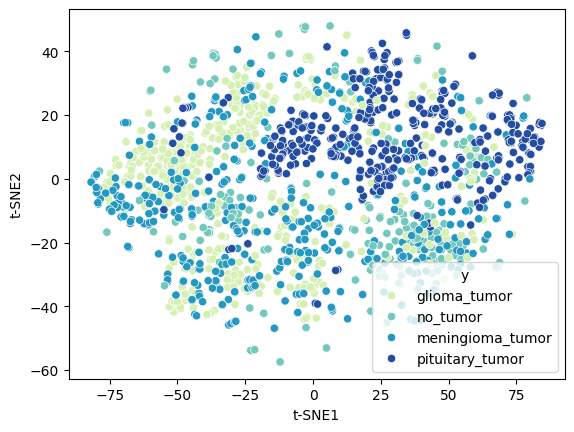

In [ ]:
#TSNE je nelinearna tehnika
from sklearn.manifold import TSNE
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Primjena TSNE
# Projiciramo originalne podatke u 2-dimenzionalni prostor
tsne = TSNE(n_components=2, init='random', random_state=0)
X_tsne_2dim = tsne.fit_transform(X_izravnan)

# Podatke spremamo u DataFrame
X_tsne_2dim = pd.DataFrame(X_tsne_2dim, columns=["t-SNE1", "t-SNE2"])
X_tsne_2dim["y"] = y  # Pretpostavljamo da je y vaša ciljna varijabla

# Vizualizacija scatter plot-a
sns.scatterplot(x="t-SNE1", y="t-SNE2", data=X_tsne_2dim, hue="y", palette="YlGnBu")
plt.show()




### PCA (Principal component)



***OSNOVNI CILJ:***  transformirati originalni skup podataka u novi skup varijabli, tzv. ***glavnih komponenata***, smjerova *najveće varijacije* u prostoru značajki.

- Svaka glavna komponenta je **linearna kombinacija** originalnih značajki.

- Glavne komponente su međusobno **ortogonalne** (okomite).

- Broj glavnih komponenata jednak je **broju originalnih značajki** u podacima.

- Redoslijed glavnih komponenti odražava smanjenje varijacije u podacima.
  - Preciznije, prva glavna komponenta (*Principal Component 1 - PC1*) predstavlja smjer najveće varijacije u podacima. Druga glavna komponenta (*Principal Component 2 - PC2*) predstavlja smjer druge najveće varijacije, i tako dalje.

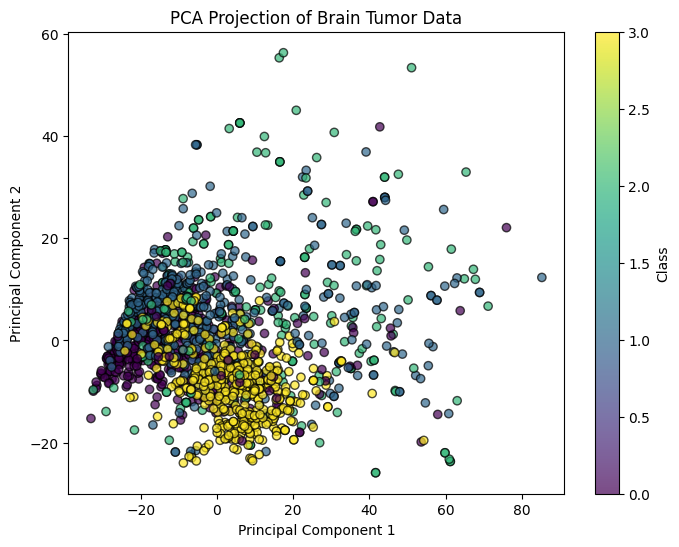

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# Inicijalizacija LabelEncoder-a
le = LabelEncoder()

# Pretvaranje klasa u numeričke oznake
y_encoded = le.fit_transform(y)

# Inicijalizacija PCA modela s brojem komponenti koje želite zadržati
num_components = 2  # Prilagodite ovisno o potrebama
pca = PCA(n_components=num_components)

# Primjena PCA na podatke
X_pca = pca.fit_transform(X_izravnan)

# Prikazivanje rezultata
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_encoded, cmap='viridis', edgecolors='k', alpha=0.7)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Projection of Brain Tumor Data')
plt.colorbar(label='Class')
plt.show()



___________________________________________________________________

#**SVM**

SVM je algoritam koji se koristi za razdvajanje dviju klasa (binarna klasifikacija) ili više klasa (višeklasna klasifikacija) stvaranjem hiperplohe u prostoru značajki. Hiperploha ima zadatak maksimizirati razmak između različitih klasa. Sloj potpornih vektora odnosi se na instance (primjere) podataka koje leže na granici razdvajanja ili su blizu nje. Ovi "potporni vektori" igraju ključnu ulogu u definiranju položaja i orijentacije hiperplohe.

###SVM

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# Inicijalizacija modela
svm_model = SVC(random_state=42)

# Treniranje modela
svm_model.fit(X_train_izravnan, y_train_num)

# Predviđanja na skupu za testiranje
y_pred = svm_model.predict(X_test_izravnan)

# Evaluacija modela
accuracy = accuracy_score(y_test_num, y_pred)

# Ispis tačnosti kao postotka
print(f"Točnost modela: {accuracy*100:.2f}%")


Točnost modela: 78.29%


In [ ]:
support_vectors_per_class = svm_model.n_support_

# Ispis broja potpornih vektora po klasama
for class_label, support_count in zip(svm_model.classes_, support_vectors_per_class):
    print(f"Broj potpornih vektora za klasu {class_label}: {support_count}")

Broj potpornih vektora za klasu 0: 312
Broj potpornih vektora za klasu 1: 360
Broj potpornih vektora za klasu 2: 252
Broj potpornih vektora za klasu 3: 265


In [ ]:
# Dobivanje svih potpornih vektora
all_support_vectors = svm_model.support_vectors_

# Ispis potpornih vektora
print("Svi potporni vektori:")
print(all_support_vectors)

Svi potporni vektori:
[[0.         0.         0.         ... 0.00392157 0.00392157 0.00392157]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.00392157 0.00392157 0.00392157]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.32941176 0.32941176 0.32941176 ... 0.32941176 0.32941176 0.32941176]]




### SVM GridSearch nad PCA podacima



Ekstrakcija značajki tj transformacija originalnih značajki u novi skup značajki<br> Transformiramo originalni skup podataka u novi skup varijabli, tzv. glavnih komponenata, smjerova najveće varijacije u prostoru značajki

Bitno je da koristimo skalirane podatke jer je PCA osjetljiv na raspon vrijednosti varijabli

Šaljemo n_components=0.95 pa će se  odabrat takav broj komponenti da udio objašnjene varijence s tim brojem komponenti bude veći od postotka specificiranog s n_components.

In [ ]:
X_izravnan.shape

(1634, 67500)

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_izravnan)
print("Shape:", X_pca.shape)
print("Num components:", pca.n_components)
print("Componetns shape:", pca.components_.shape)
print(f"Explained variance: {pca.explained_variance_ratio_.sum()*100:.2f}%")

Shape: (1634, 607)
Num components: 0.95
Componetns shape: (607, 67500)
Explained variance: 95.01%


Br komponenti se smanjio sa 67500 na 607

Numeričko kodiranje i podjela na train i test

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Inicijalizacija i fitiranje LabelEncoder-a na kombiniranom skupu podataka
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Podijela podataka X i y (kodiranih) na train i test skupove
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y_encoded, test_size=0.2, random_state=42)

Grid Search je tehnika optimizacije hiperparametara

Sporo unatoc PCA pa sam zakomentirala model.fit:

In [ ]:
import pandas as pd
import os
from skimage.transform import resize
from skimage.io import imread
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report


# Defining the parameters grid for GridSearchCV
param_grid={'C':[0.1,1,10,100],
            'gamma':[0.0001,0.001,0.1,1],
            'kernel':['rbf','poly']}

# Creating a support vector classifier
svc=svm.SVC(probability=True)

# Creating a model using GridSearchCV with the parameters grid
model=GridSearchCV(svc,param_grid)


# Training the model using the training data
#model.fit(X_train_pca,y_train_freq)     #SPORO unatoc PCA

###SVM OneVsRestClassifier nad PCA podacima

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
# Define SVM parameters
svm_params = {
    'C': 1.0,
    'gamma': 'scale',  # You can adjust this based on your data
    'kernel': 'rbf'    # You can choose 'poly' or other kernels based on your needs
}

# Create a support vector classifier
svc = SVC(**svm_params, probability=True)

# Wrap the classifier in OneVsRestClassifier
model = OneVsRestClassifier(svc)

# Train the model
model.fit(X_train_pca, y_train_pca)

# Predictions
y_pred = model.predict(X_test_pca)

# Calculate accuracy
accuracy = accuracy_score(y_test_pca, y_pred)

print(f"Točnost modela: {accuracy*100:.2f}%")

Točnost modela: 77.98%


Standardna implementacija SVM klasifikatora SVC daje veću točnost nego OneVsRestClassifier.

#**Logistička regresija**



##Multinomialna logistička regresija (generalizacija binarne na više od 2 klase)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import numpy as np

model = LogisticRegression(multi_class="multinomial")

# Train the model
model.fit(X_train_izravnan, y_train_num)

# Make predictions
y_pred = model.predict(X_test_izravnan)

# Evaluacija performansi modela
accuracy = accuracy_score(y_test_num, y_pred)

# Ispis rezultata
print('Točnost za {} iteracija: {}%'.format(100, np.round(accuracy, 4) * 100))

Točnost za 100 iteracija: 73.39%


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


##One vs rest logistička regresija (transformira višeklasni problem u više binarnih problema)

In [ ]:
model = LogisticRegression(multi_class="ovr")

# Train the model
model.fit(X_train_izravnan, y_train_num)

# Make predictions
y_pred = model.predict(X_test_izravnan)

# Evaluacija performansi modela
accuracy = accuracy_score(y_test_num, y_pred)

# Ispis rezultata
print('Točnost za {} iteracija: {}%'.format(100, np.round(accuracy, 4) * 100))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Točnost za 100 iteracija: 72.78%


Veću točnost daje multinomialna logistička regresija.

# **Naivni Bayes**

Familija algoritama koje koristimo za klasifikacija , osnovna "naivna" pp je da su značajke/varijable nezavisne

Značajke su numeričke/kontinuirane i pretpostavljamo da su podaci normalno distribuirani

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report

# Inicijalizacija modela Gaussian Naive Bayes
gnb = GaussianNB()

# Treniranje modela na skupu za treniranje
gnb.fit(X_train_izravnan, y_train_num)

# Predviđanje na skupu za testiranje
y_pred = gnb.predict(X_test_izravnan)

# Evaluacija performansi modela
accuracy = accuracy_score(y_test_num, y_pred)
print("Točnost modela:", accuracy)

# Ispisivanje izvještaja o klasifikaciji
print("Izvještaj o klasifikaciji:\n", classification_report(y_test_num, y_pred))


Točnost modela: 0.5412844036697247
Izvještaj o klasifikaciji:
               precision    recall  f1-score   support

           0       0.46      0.90      0.61        96
           1       0.39      0.08      0.13        87
           2       0.58      0.52      0.55        58
           3       0.75      0.63      0.68        86

    accuracy                           0.54       327
   macro avg       0.55      0.53      0.49       327
weighted avg       0.54      0.54      0.49       327



Zašto je točnost niska?

In [ ]:
from scipy.stats import anderson, shapiro, kstest

# Odaberite klasu i značajku za koje želite provesti testove normalnosti
klasa = 'glioma_tumor'
značajka = 0  # Postavite na indeks željene značajke

# Izdvojite vrijednosti značajke za odabranu klasu
feature_values = X[y == klasa][:, značajka].reshape(-1)

# Kolmogorov-Smirnov test za normalnost
stat, p_value = kstest(feature_values, 'norm')
print(f"Kolmogorov-Smirnov test za {klasa}, značajka {značajka + 1}: {stat}, p-vrijednost: {p_value}")


Kolmogorov-Smirnov test za glioma_tumor, značajka 1: 0.5, p-vrijednost: 0.0


Kolmogorov-Smirnov test za glioma_tumor, značajka 1: 0.5, p-vrijednost: 0.0

Kolmogorov-Smirnov test također provjerava normalnost podataka. Statistička vrijednost testa je 0.5, a p-vrijednost je 0.0. Kao i kod drugih testova, niska p-vrijednost sugerira da podaci nisu normalno distribuirani.

**Zaključak:**

Iako Naivni Bayes može biti koristan za klasifikaciju u nekim slučajevima, obično se koristi za obradu tekstualnih podataka i podataka s diskretnim značajkama. Kada su u pitanju slike, posebno one u kojima su susjedni pikseli često povezani, modeli kao što su konvolucijske neuronske mreže (CNN) često daju bolje rezultate jer mogu naučiti prostorne značajke i odnose između piksela




Naivni Bayes modeli, uključujući Gaussian Naive Bayes , često nisu najbolji izbor za klasifikaciju slika iz nekoliko razloga:

Pretpostavka o nezavisnosti značajki: Naivni Bayes modeli pretpostavljaju nezavisnost značajki, što može biti neprikladno za slike. Pixeli u slici često imaju kompleksne međusobne ovisnosti, posebno kada se radi o slikama visoke rezolucije

Problemi s dimenzionalnošću: Slike obično imaju veliki broj dimenzija (svaki piksel predstavlja jednu dimenziju). Kada imamo puno dimenzija, NB modeli mogu imati problema s previše parametara koje treba procijeniti, a to može dovesti do visokih zahtjeva za memorijom i vremenom izvođenja

Ograničenje na linearne ovisnosti: GNB pretpostavlja normalnu distribuciju značajki, što može ograničiti sposobnost modela da se nosi s kompleksnim ne-linearnim odnosima u podacima, što često vidimo u slikama



________________________________________________________________________________

#**Stabla odluke**

###Stabla odluke

Ne zahtijevaju skaliranje podataka, ali smo ih već skalirali

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf.fit(X_train_izravnan, y_train_num)

DecisionTreeClassifier()

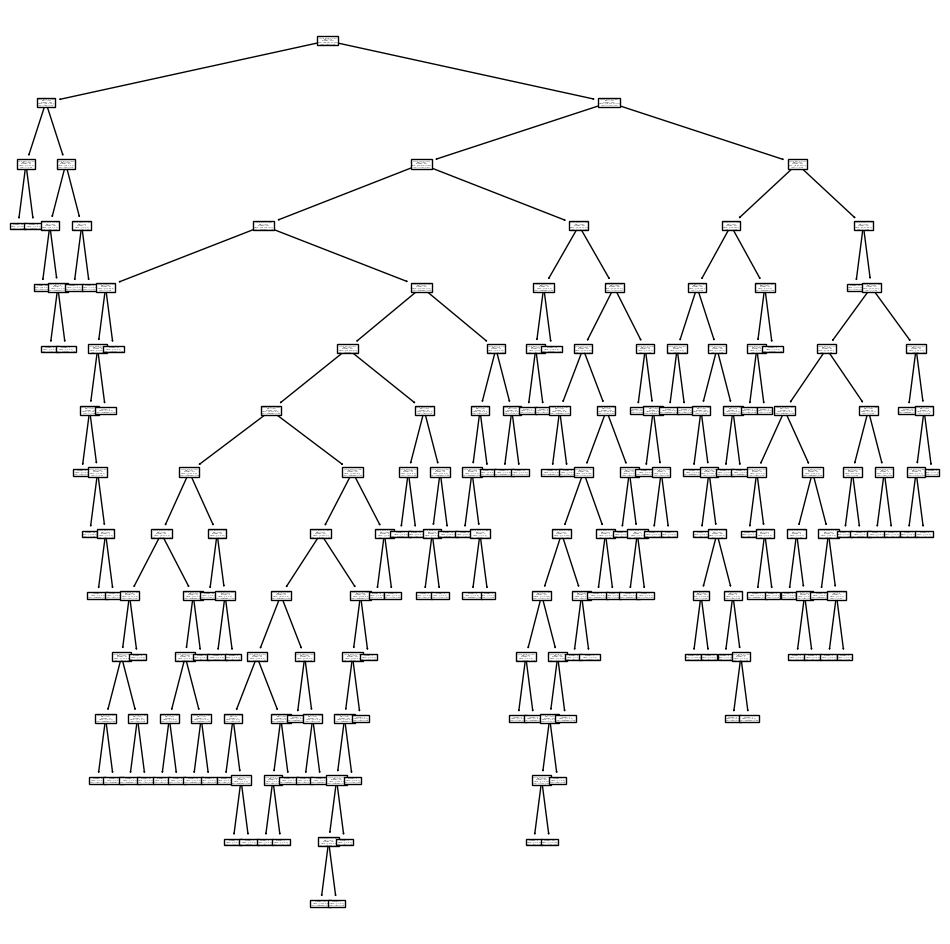

In [ ]:
# Generiranje imena značajki
num_features = 150 * 150 * 3
feature_names = [f"feature_{i+1}" for i in range(num_features)]

# Postavljanje veličine figure
plt.figure(figsize=(12, 12))

# Crtanje stabla odluke
tree.plot_tree(clf, feature_names=feature_names, class_names=['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor'])

# Prikazivanje grafa
plt.show()


In [ ]:
from sklearn.tree import export_graphviz
import graphviz

# Generiranje imena značajki
num_features = 150 * 150 * 3
feature_names = [f"feature_{i+1}" for i in range(num_features)]

# Export grafa odluke u DOT format
dot_data = export_graphviz(clf,
                           out_file=None,
                           feature_names=feature_names,
                           class_names=['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor'],
                           filled=True,
                           rounded=True,
                           special_characters=True)

# Konvertiranje DOT formata u grafički prikaz
graph = graphviz.Source(dot_data)
graph.render("decision_tree_plot", format="png")  # Ovo će stvoriti PNG datoteku s imenom "decision_tree_plot.png"
graph.view("decision_tree_plot")  # Ovo će prikazati grafički prikaz u pregledniku


'decision_tree_plot.pdf'

my drive search decision_tree_plot.png tu se pojavi slika stabla

In [ ]:
from sklearn import metrics
y_pred = clf.predict(X_train_izravnan)
acc = metrics.accuracy_score(y_train_num, y_pred)
print(f"Točnost na skupu za treniranje: {acc*100:.2f}%")

Točnost na skupu za treniranje: 100.00%


In [ ]:
y_pred = clf.predict(X_test_izravnan)
acc = metrics.accuracy_score(y_test_num, y_pred)
print(f"Točnost na skupu za testiranje: {acc*100:.2f}%")

Točnost na skupu za testiranje: 67.89%


**Komentar:** <br>
Došlo je do prenaučenosti (overfitting) modela.

 Kada sam koristila y kodiran one-hot točnost je bila za 1% manja.

**Komentar:**

Stabla odluke mogu se koristiti za klasifikaciju slika, ali nisu uvijek najbolji izbor, pogotovo ako je riječ o većim skupovima podataka s visokom rezolucijom. Stabla odluke imaju određene prednosti i nedostatke u kontekstu klasifikacije slika:

Prednosti:

Jednostavna interpretacija: Stabla odluke omogućuju lako tumačenje donesenih odluka, jer možete pratiti put koji je model slijedio kako bi donio određenu klasifikaciju.

Otpornost na neke oblike preprocesiranja: Stabla odluke mogu raditi dobro s podacima koji nisu potpuno obrađeni ili normalizirani, što ih čini robusnim u određenim situacijama.

Nedostaci:

Nedostatak sposobnosti učenja složenih značajki: Stabla odluke ne uvode automatski hijerarhiju u podacima kao što to čine konvolucijske neuronske mreže (CNN). To znači da mogu imati problema s prepoznavanjem složenih značajki u slikama.

Nedostatak robusnosti na varijacije u podacima: Stabla odluke mogu biti osjetljiva na male promjene u podacima, što ih čini manje robusnima u odnosu na druge modele, posebno kada su podaci šumoviti ili kada postoji velika varijacija u slikama.

Ograničenja učenja iz velikih skupova podataka: Za velike skupove podataka s visokom dimenzionalnošću, stabla odluke mogu postati prekomjerno složena i teška za treniranje, što dovodi do problema s prenaučenošću.

##Slučajne šume

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf_rf = RandomForestClassifier()
clf_rf.fit(X_train_izravnan, y_train_num)
y_pred_rf = clf_rf.predict(X_test_izravnan)

acc_test = metrics.accuracy_score(y_test_num, y_pred_rf)
print(f"Točnost na skupu za testiranje: {acc_test*100:.2f}%")

Točnost na skupu za testiranje: 82.87%


**Komentar:** <br>  Poboljšala se točnost u odnosu na stablo.

##Podrezivanje stabla (max dubina 3)

In [ ]:
pruned_model = DecisionTreeClassifier(max_depth=3, random_state=42)
pruned_model.fit(X_train_izravnan, y_train_num)

DecisionTreeClassifier(max_depth=3, random_state=42)

In [ ]:
pruned_train_accuracy = pruned_model.score(X_train_izravnan, y_train_num)
print(f'Pruned Training Accuracy: {pruned_train_accuracy}') ##koristimo tocnost kao metriku

Pruned Training Accuracy: 0.6819371727748691


In [ ]:
pruned_test_accuracy = pruned_model.score(X_test_izravnan, y_test_num)
print(f'Pruned Test Accuracy: {pruned_test_accuracy}')

Pruned Test Accuracy: 0.6146788990825688


**Komentar:** <br>
Loše rezano stablo, točnost se smanjila.

Mogli bi Koristeći GridSearch metodu, ispitajte koja bi bila "najbolja" kombinacija hiperparametara max_depth and min_samples_leaf (ali dugo traje)

_________________________________________________________

#**Neuronske mreže**

###**CNN(Konvolucijske neuronske mreže)**
3 modela

**Model 1**

Sekvencijalni model sa nekoliko slojeva :

1.konvolucijski slojevi (Conv2D) s ReLU aktivacijskom funkcijom

2.slojevi za maksimalno uzorkovanje (MaxPooling2D) radi smanjenja dimenzionalnosti slike

3.sloj za ravnanje podataka (Flatten)

4.potpuno povezani slojevi (Dense) s ReLU i softmax aktivacijskim funkcijama.

Ulazni oblik slike je (150, 150, 3), što sugerira da su slike dimenzija 150x150 piksela u RGB formatu.

Model se kompilira s optimizatorom 'adam' i funkcijom gubitka CategoricalCrossentropy (klase kodirane sa onehot). Također se prate metrike točnosti.

Model se trenira na obuci s nizom podataka X_train i pripadajućim oznakama y_train_onehot.

Broj epoha za treniranje postavljen je na 10, a validacijski skup (X_test, y_test_onehot) se koristi za procjenu performansi modela tijekom treniranja.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical

# Pretvaranje imena klasa u one-hot kodirane vektore            ako u y imena klasa ond pretv u one hot vektore i loss function CategoricalCrossentropy
#ako u y numericki ozn klase 0,1,2,3 onda ostavljas posatke takvima i               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),


# Prilagodba modela za 4 klase
model1 = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(4, activation='softmax')  # Broj izlaza postavljen na 4 za 4 klase
])

# Kompilacija modela s CategoricalCrossentropy
model1.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

# Pregledavanje arhitekture modela
model1.summary()

# Treniranje modela
povijest=model1.fit(X_train, y_train_onehot, epochs=10, validation_data=(X_test, y_test_onehot))

# Evaluacija modela na testnom skupu
test_loss, test_accuracy = model1.evaluate(X_test, y_test_onehot,verbose=2)

print(f"\nTočnost na testnom skupu: {test_accuracy * 100:.2f}%")



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)       0

Prikaz grafa točnosti i gubitka kroz epohe tijekom treniranja

Korisno za praćenje konvergencije modela, detekciju prenaučenosti (overfitting tj točnost na trening skupu značajno veća od točnosti na validacijskom skupu) ili podnaučenosti (underfitting), te za optimizaciju hiperparametara modela

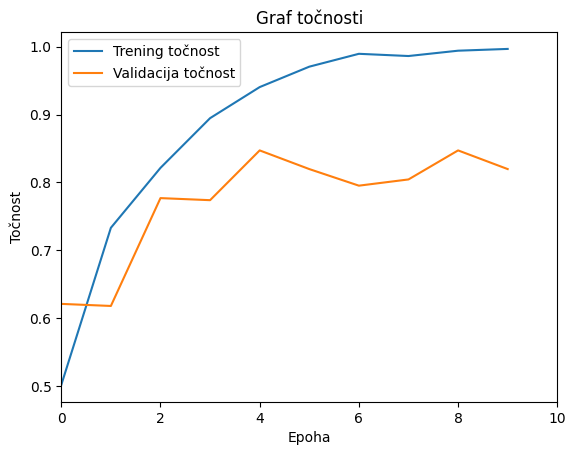

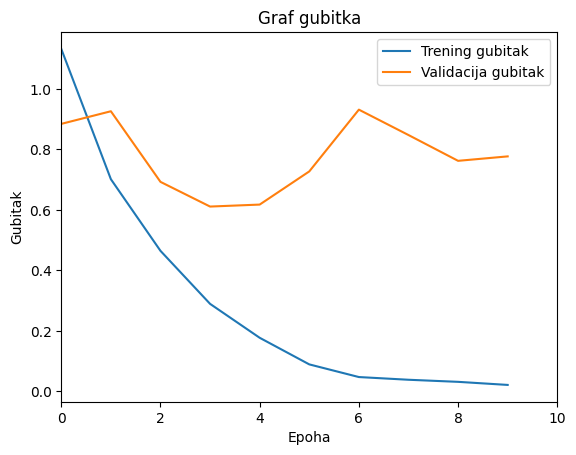

In [ ]:
plt.plot(povijest.history['accuracy'], label='Trening točnost')
plt.plot(povijest.history['val_accuracy'], label='Validacija točnost')
plt.title('Graf točnosti')
plt.xlabel('Epoha')
plt.ylabel('Točnost')
plt.legend()
plt.xlim(0, len(povijest.history['accuracy']) )  # Postavljanje raspona osi x od 0 do posljednje epohe
plt.show()

plt.plot(povijest.history['loss'], label='Trening gubitak')
plt.plot(povijest.history['val_loss'], label='Validacija gubitak')
plt.title('Graf gubitka')
plt.xlabel('Epoha')
plt.ylabel('Gubitak')
plt.legend()
plt.xlim(0, len(povijest.history['loss']) )  # Postavljanje raspona osi x od 0 do posljednje epohe
plt.show()


Pokušala sam iz slike naći optimalan broj epoha

In [ ]:
# Treniranje modela
povijest_nova=model1.fit(X_train, y_train_onehot, epochs=4, validation_data=(X_test, y_test_onehot))

# Evaluacija modela na testnom skupu
test_loss, test_accuracy = model1.evaluate(X_test, y_test_onehot,verbose=2)

print(f"\nTočnost na testnom skupu: {test_accuracy * 100:.2f}%")


Epoch 1/4
48/48 [==============================] - 3s 46ms/step - loss: 0.0071 - accuracy: 0.9987 - val_loss: 0.7744 - val_accuracy: 0.8563
Epoch 2/4
48/48 [==============================] - 2s 38ms/step - loss: 0.0077 - accuracy: 0.9993 - val_loss: 0.7082 - val_accuracy: 0.8502
Epoch 3/4
48/48 [==============================] - 2s 37ms/step - loss: 0.0067 - accuracy: 0.9993 - val_loss: 0.8095 - val_accuracy: 0.8287
Epoch 4/4
48/48 [==============================] - 2s 38ms/step - loss: 0.0117 - accuracy: 0.9987 - val_loss: 0.7353 - val_accuracy: 0.8471
11/11 - 0s - loss: 0.7353 - accuracy: 0.8471 - 176ms/epoch - 16ms/step

Točnost na testnom skupu: 84.71%


Povećala se točnost

**Model 2**

Inicijalizacija modela: Model se inicijalizira kao sekvenca slojeva korištenjem Sequential() modela iz Kerasa.

Dodavanje konvolucijskih slojeva: Dodaju se dva sloja konvolucije (Conv2D) s 32 i 64 filtera, veličinom kernela 5x5, aktivacijskom funkcijom ReLU i ulaznim oblikom slike dimenzija 150x150 piksela u RGB formatu.

Dodavanje slojeva za maksimalno uzorkovanje (Pooling): Nakon svakog konvolucijskog sloja dodaje se sloj za maksimalno uzorkovanje (MaxPooling2D) s veličinom poola 2x2.

Ravnanje podataka: Nakon slojeva za maksimalno uzorkovanje, dodaje se sloj za ravnanje (Flatten) koji pretvara višedimenzionalne izlaze konvolucijskih slojeva u jednodimenzionalni vektor kako bi se mogli proslijediti potpuno povezanim slojevima.

Dodavanje potpuno povezanih slojeva: Nakon sloja za ravnanje, dodaju se dva potpuno povezana sloja (Dense) s 16 i 4 neurona, aktivacijskom funkcijom ReLU za skriveni sloj i softmax za izlazni sloj. Softmax sloj osigurava da izlazi mreže predstavljaju vjerojatnosti za svaku od četiri klase.

Model se kompilira s funkcijom gubitka sparse_categorical_crossentropy (klase kodirane numerički) , optimizatorom 'adam' i metrikama točnosti.

Model se trenira s nizom podataka X_train i pripadajućim numeričkim oznakama klasa y_train_num tijekom 15 epoha, koristeći grupu veličine 64 i s 20% podataka koristeći za validaciju

In [ ]:
model2 = tf.keras.models.Sequential()

model2.add(tf.keras.layers.Conv2D(32, kernel_size=(5, 5), input_shape=(150, 150, 3), activation='relu'))
model2.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
model2.add(tf.keras.layers.Conv2D(64, kernel_size=(5, 5), activation='relu'))
model2.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))

model2.add(tf.keras.layers.Flatten())

model2.add(tf.keras.layers.Dense(16, activation='relu'))
model2.add(tf.keras.layers.Dense(4, activation='softmax'))

model2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model2.summary()

povijest2 = model2.fit(X_train, y_train_num, epochs=15, batch_size=64, validation_split=0.2)

_, test_acc = model2.evaluate(X_test, y_test_num, verbose=0)
print("Točnost na skupu za testiranje: {:.2f}%".format(test_acc * 100))


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 146, 146, 32)      2432      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 73, 73, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 69, 69, 64)        51264     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 34, 34, 64)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 73984)             0         
                                                                 
 dense_2 (Dense)             (None, 16)               

Prikaz grafa točnosti i gubitka kroz epohe tijekom treniranja

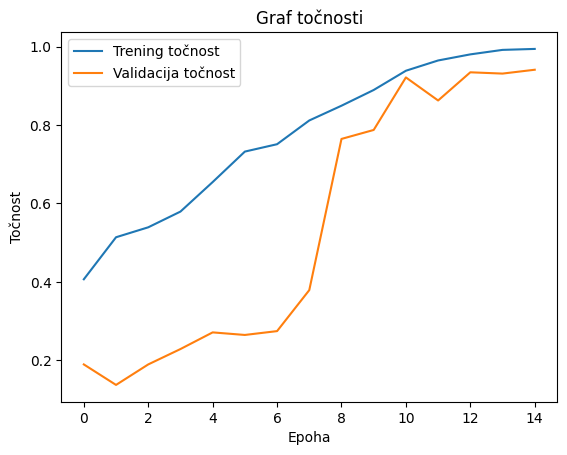

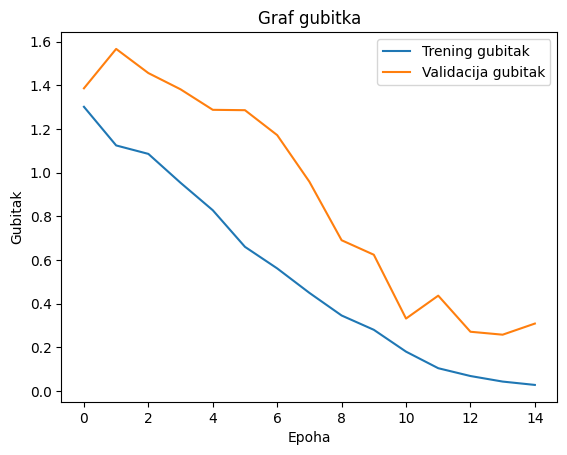

In [ ]:
import matplotlib.pyplot as plt

# Prikazivanje grafa tačnosti
plt.plot(povijest2.history['accuracy'], label='Trening točnost')
plt.plot(povijest2.history['val_accuracy'], label='Validacija točnost')
plt.title('Graf točnosti')
plt.xlabel('Epoha')
plt.ylabel('Točnost')
plt.legend()
plt.show()

# Prikazivanje grafa gubitka
plt.plot(povijest2.history['loss'], label='Trening gubitak')
plt.plot(povijest2.history['val_loss'], label='Validacija gubitak')
plt.title('Graf gubitka')
plt.xlabel('Epoha')
plt.ylabel('Gubitak')
plt.legend()
plt.show()


Pokušala sam iz slike naći optimalan broj epoha

In [ ]:
povijest2_nova = model2.fit(X_train, y_train_num, epochs=10, batch_size=64, validation_split=0.2)

_, test_acc = model2.evaluate(X_test, y_test_num, verbose=0)
print("Točnost na skupu za testiranje: {:.2f}%".format(test_acc * 100))

Epoch 1/10
20/20 [==============================] - 3s 101ms/step - loss: 0.0192 - accuracy: 0.9951 - val_loss: 0.2704 - val_accuracy: 0.9575
Epoch 2/10
20/20 [==============================] - 1s 69ms/step - loss: 0.0160 - accuracy: 0.9959 - val_loss: 0.2907 - val_accuracy: 0.9477
Epoch 3/10
20/20 [==============================] - 1s 67ms/step - loss: 0.0150 - accuracy: 0.9959 - val_loss: 0.2667 - val_accuracy: 0.9575
Epoch 4/10
20/20 [==============================] - 1s 60ms/step - loss: 0.0161 - accuracy: 0.9951 - val_loss: 0.2993 - val_accuracy: 0.9477
Epoch 5/10
20/20 [==============================] - 1s 64ms/step - loss: 0.0119 - accuracy: 0.9959 - val_loss: 0.3217 - val_accuracy: 0.9510
Epoch 6/10
20/20 [==============================] - 2s 80ms/step - loss: 0.0148 - accuracy: 0.9967 - val_loss: 0.2637 - val_accuracy: 0.9542
Epoch 7/10
20/20 [==============================] - 2s 93ms/step - loss: 0.0129 - accuracy: 0.9967 - val_loss: 0.2942 - val_accuracy: 0.9510
Epoch 8/10
2

Povećala se točnost

**Model 3**

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

Definiram broj epoha i batch size (veličina grupa)

In [ ]:
BR_EPOHA = 50
BATCH_SIZE = 64

Model ima složeniju arhitekturu s više slojeva.

Prvi CONV blok:

Dva sloja konvolucijskih slojeva (Conv2D) s 32 filtera veličine (3, 3) i aktivacijskom funkcijom ReLU.
Oba sloja imaju istu veličinu za izlaznu sliku (padding='same'), što rezultira istim dimenzijama ulazne slike.
Nakon toga slijedi sloj za maksimalno uzorkovanje (MaxPooling2D) s veličinom prozora (2, 2), koji smanjuje dimenzionalnost izlazne slike.

Drugi CONV blok:

Ponavlja se ista struktura kao i u prvom bloku, ali sada s dvostruko više filtera, odnosno 64.

Treći CONV blok:

Ponovno se ponavlja struktura, ali sada s 128 filtera.

Klasifikacijska "glava":

Nakon tri bloka konvolucija, slijedi sloj za ravnanje podataka (Flatten), koji pretvara višedimenzionalne podatke u jednodimenzionalni oblik kako bi se mogli priključiti potpuno povezani slojevi.
Slijedi dva potpuno povezana (Dense) sloja s aktivacijskom funkcijom ReLU. Prvi skriveni sloj ima 128 neurona.
Na kraju, izlazni sloj s četiri neurona koristi softmax aktivacijsku funkciju za klasifikaciju u četiri različite klase.

Kompilacija modela:

Model se kompilira s optimizatorom 'adam' i funkcijom gubitka 'categorical_crossentropy'.
Prati se metrika točnosti.

In [ ]:
def osnovni_model():
  model = tf.keras.models.Sequential()

  # 1. CONV blok
  model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(150, 150, 3)))
  model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
  model.add(tf.keras.layers.MaxPool2D((2, 2)))

  # 2. CONV blok
  model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
  model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
  model.add(tf.keras.layers.MaxPool2D((2, 2)))

  # 3. CONV blok
  model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
  model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
  model.add(tf.keras.layers.MaxPool2D((2, 2)))

  # 4. klasifikacijska "glava"
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(128, activation='relu'))
  model.add(tf.keras.layers.Dense(4, activation='softmax'))

  model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  return model

Prikazivanje povijesti (history) metrika tijekom treniranja modela neuronske mreže.

In [ ]:
def plot_history(hist_baseline, hist_regularized=None):

    fig = plt.figure(figsize = (17,5))
    metrics = ["loss", "accuracy"]

    for i in range(len(metrics)):
        metric = metrics[i]
        plt.subplot(1, 2, i+1)
        plt.title(metric.capitalize())
        plt.xlabel("epoha")
        plt.ylabel(metric)
        br_epoha = len(hist_baseline.history[metric])
        plt.plot(range(1, br_epoha + 1), hist_baseline.history[metric],
                 label="train", color="tab:blue")
        plt.plot(range(1, br_epoha + 1), hist_baseline.history["val_" + metric],
                 label="val", color="tab:orange")

        if hist_regularized:
            br_epoha = len(hist_regularized.history[metric])
            plt.plot(range(1, br_epoha + 1), hist_regularized.history[metric],
                 label="regularized train", color="tab:blue", linestyle='--')
            plt.plot(range(1, br_epoha + 1), hist_regularized.history["val_" + metric],
                 label="regularized val", color="tab:orange", linestyle='--')
        plt.legend()

Ispisivanje točnosti (accuracy) modela na testnom skupu podataka.

In [ ]:
def print_acc(model):
  _, acc = model.evaluate(X_test, y_test_onehot, verbose=0)
  print('Accuracy (test data): {:.2f} %'.format(acc*100))

Definiranje, treniranje i evaluiranje osnovnog modela neuronske mreže, te pohranjiavanje povijest treniranja u varijablu baseline_hist.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Očistimo prethodno definirani graf modela
tf.keras.backend.clear_session()

model_baseline = osnovni_model()
model_baseline.summary()

# Treniranje modela
baseline_hist = model_baseline.fit(X_train, y_train_onehot, epochs=BR_EPOHA, batch_size=BATCH_SIZE, validation_split=0.2)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 150, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 75, 75, 32)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 75, 75, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 37, 37, 64)        0         
 g2D)                                                   

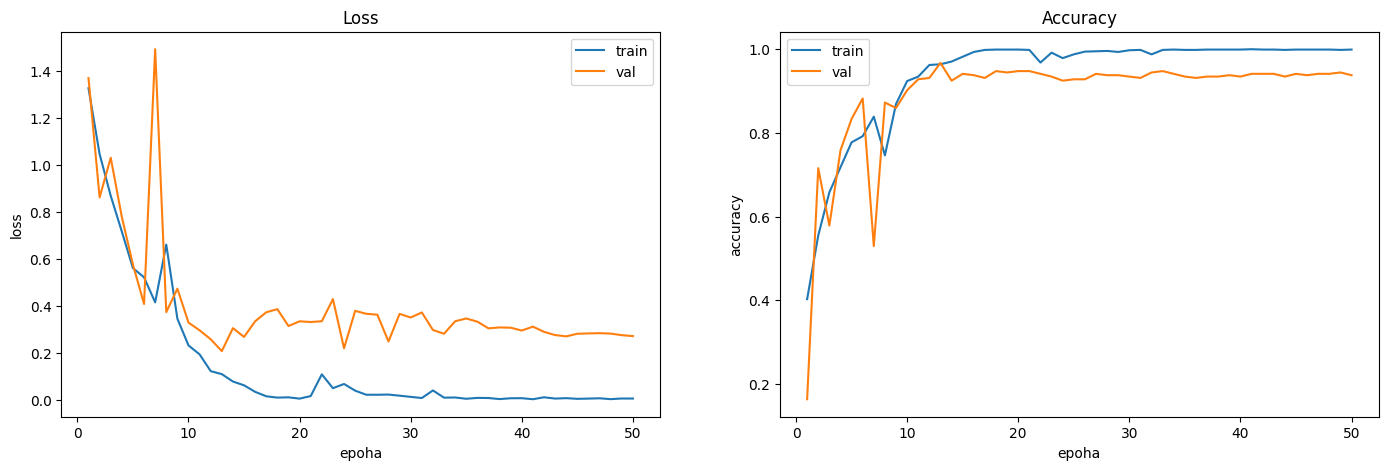

In [ ]:
plot_history(baseline_hist)

In [ ]:
print_acc(model_baseline)

Accuracy (test data): 82.87 %


###Nastavimo sada sa radom na Modelu 3

**Vjerojatnost pripadanja određenoj klasi**

In [ ]:
model=model_baseline

 Ručni izračuna točnosti.

 Metoda predict modela prima ulazne podatke i vraća predikcije modela za svaki ulaz.

  Predikcije koje su vraćene kao vjerojatnosti klasa pretvaraju se u konkretne klasne oznake. To se radi pomoću funkcije argmax koja pronalazi indeks maksimalne vrijednosti za svaki primjer u predikcijama.

Izračunava se točnost predikcija tako što se uspoređuju predikcije modela (predicted_labels) s stvarnim oznakama testnog skupa (y_test_num). Uspoređivanje se obavlja element po element, vraćajući niz boolean vrijednosti. Zatim se poziva np.mean funkcija koja izračunava prosječnu vrijednost niza boolean vrijednosti, što daje točnost predikcija u rasponu od 0 do 1.


In [ ]:
import numpy as np

# Make predictions on test set
predictions = model.predict(X_test)

# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Evaluate predictions
accuracy = np.mean(predicted_labels == y_test_num) ## If you started with one-hot encoding, convert it back to class labels,zato ovde y_test_num

print(f"\nTočnost predikcija na testnom skupu: {accuracy * 100:.2f}%")


11/11 [==============================] - 0s 18ms/step

Točnost predikcija na testnom skupu: 82.87%


In [ ]:
predictions

array([[6.33530306e-07, 7.40016004e-09, 3.44657036e-09, 9.99999404e-01],
       [1.30082105e-08, 3.70956006e-13, 8.15626777e-07, 9.99999166e-01],
       [2.49805227e-02, 3.84184599e-01, 5.90834796e-01, 7.42396509e-08],
       ...,
       [9.99996424e-01, 3.54993631e-06, 7.96018016e-15, 3.34533130e-11],
       [9.96249974e-01, 3.75004974e-03, 3.51708072e-12, 1.56267807e-13],
       [5.45190119e-07, 1.15825449e-09, 4.75213369e-10, 9.99999404e-01]],
      dtype=float32)

In [ ]:
predictions.shape

(327, 4)

In [ ]:
predicted_labels

array([3, 3, 2, 2, 1, 3, 2, 0, 3, 1, 2, 1, 1, 3, 3, 2, 1, 2, 2, 2, 0, 1,
       2, 1, 1, 0, 3, 2, 2, 1, 1, 0, 3, 2, 1, 1, 2, 1, 0, 1, 1, 1, 2, 0,
       2, 3, 2, 2, 0, 0, 0, 1, 3, 0, 1, 1, 0, 2, 0, 0, 1, 0, 2, 0, 0, 0,
       2, 1, 3, 2, 2, 0, 1, 2, 0, 1, 3, 3, 0, 2, 0, 1, 1, 3, 0, 3, 3, 1,
       3, 0, 1, 2, 0, 1, 0, 0, 3, 1, 3, 3, 3, 2, 3, 1, 1, 3, 1, 1, 3, 3,
       2, 2, 3, 0, 3, 2, 2, 3, 3, 2, 1, 0, 0, 3, 2, 3, 3, 3, 1, 2, 3, 1,
       1, 3, 0, 1, 1, 2, 0, 1, 3, 0, 0, 2, 1, 2, 2, 3, 0, 1, 0, 0, 3, 1,
       1, 3, 0, 3, 0, 3, 0, 1, 0, 2, 3, 1, 3, 3, 3, 3, 0, 2, 1, 0, 0, 2,
       3, 1, 1, 3, 0, 2, 1, 1, 3, 1, 0, 3, 3, 1, 2, 3, 0, 3, 2, 3, 1, 0,
       1, 1, 0, 2, 3, 0, 1, 2, 3, 1, 2, 1, 1, 0, 2, 0, 1, 1, 0, 3, 0, 3,
       3, 0, 0, 1, 3, 1, 1, 3, 2, 1, 1, 1, 0, 3, 0, 3, 3, 1, 0, 3, 3, 1,
       1, 0, 0, 2, 3, 0, 0, 2, 2, 1, 0, 0, 1, 1, 0, 1, 3, 3, 0, 1, 0, 1,
       0, 1, 3, 3, 1, 0, 3, 3, 3, 0, 1, 0, 0, 0, 3, 0, 3, 0, 1, 1, 3, 1,
       0, 1, 1, 2, 0, 3, 0, 3, 2, 0, 2, 2, 2, 3, 1,

In [ ]:
predicted_labels.shape

(327,)

**Normalizirana vjerojatnost pripadanja svakoj klasi (u sumi 1)**

Stvara se novi model probability_model koji se sastoji od postojećeg modela (model) i dodatnog sloja Softmax. Sloj Softmax se koristi za pretvaranje izlaznih vrijednosti modela u vjerojatnosti. Time se osigurava da izlazni vektor sadrži vjerojatnosti svake klase, čime se omogućuje lakša interpretacija predikcija.

Predikcije koje su vraćene kao vjerojatnosti klasa pretvaraju se u konkretne klasne oznake.

Izračunava se točnost predikcija tako što se uspoređuju predikcije modela (predicted_labels_prob) s stvarnim oznakama testnog skupa (y_test_num). Uspoređivanje se obavlja element po element, vraćajući niz boolean vrijednosti. Zatim se poziva np.mean funkcija koja izračunava prosječnu vrijednost niza boolean vrijednosti, što daje točnost predikcija u rasponu od 0 do 1.

In [ ]:
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])
# Make predictions with probability_model on test set
probability_predictions = probability_model.predict(X_test)

# Convert predictions to class labels
predicted_labels_prob = np.argmax(probability_predictions, axis=1)

# If you started with one-hot encoding, convert it back to class labels
# predicted_labels_prob = np.argmax(probability_predictions, axis=1)

# Evaluate predictions
accuracy_prob = np.mean(predicted_labels_prob == y_test_num)
print(f"\nTočnost predikcija (sa softmax) na testnom skupu: {accuracy_prob * 100:.2f}%")


11/11 [==============================] - 0s 14ms/step

Točnost predikcija (sa softmax) na testnom skupu: 82.87%


In [ ]:
probability_predictions

array([[0.17487787, 0.17487776, 0.17487776, 0.4753667 ],
       [0.17487776, 0.17487776, 0.1748779 , 0.4753666 ],
       [0.19348088, 0.27710122, 0.34071043, 0.18870752],
       ...,
       [0.47536573, 0.17487854, 0.17487791, 0.17487791],
       [0.4741197 , 0.17573196, 0.17507419, 0.17507419],
       [0.17487784, 0.17487776, 0.17487776, 0.4753667 ]], dtype=float32)

In [ ]:
predictions[0]

array([6.3353031e-07, 7.4001600e-09, 3.4465704e-09, 9.9999940e-01],
      dtype=float32)

Indeks klase s najvećom predikcijom za prvi primjer u skupu podataka.

In [ ]:
np.argmax(predictions[0])

3

Stvarna klasa za prvi primjer u skupu podataka.

In [ ]:
y_test_num[0]

3

Vidimo da su predviđena i stvarna klasa jednake tj primjer je dobro razvrstan u klasu 'pituitary_tumor'.

In [ ]:
y_test[0]

'pituitary_tumor'

**Matrica konfuzije**

Matrica konfuzije i prikaz je pomoću toplinske karte (heatmap) pomoću biblioteka seaborn i matplotlib.pyplot.

Pruža uvid u to kako model klasificira primjere u svakoj od klasa.

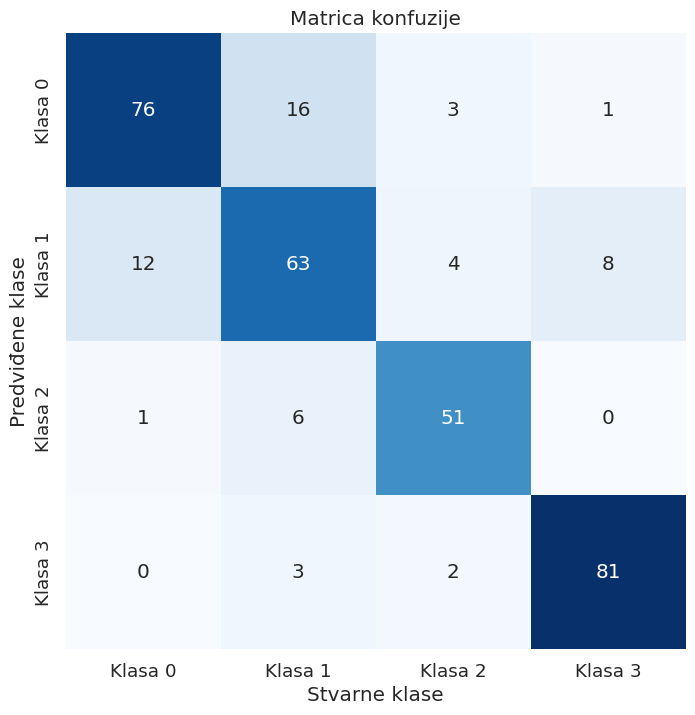

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# Izračunajte matricu konfuzije
conf_mat = confusion_matrix(y_test_num, predicted_labels)

# Plotiranje matrice konfuzije
plt.figure(figsize=(8, 8))
sns.set(font_scale=1.2)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=["Klasa 0", "Klasa 1", "Klasa 2", "Klasa 3"],
            yticklabels=["Klasa 0", "Klasa 1", "Klasa 2", "Klasa 3"])
plt.xlabel('Stvarne klase')
plt.ylabel('Predviđene klase')
plt.title('Matrica konfuzije')
plt.show()


**Promotrimo** detaljnije dobivena predviđanja

Definiramo dvije funkcije koje se koriste za prikazivanje predikcija modela i njihovih vjerojatnosti.

In [ ]:
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(labels[predicted_label],
                                100*np.max(predictions_array),
                                labels[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(4))
  plt.yticks([])
  thisplot = plt.bar(range(4), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

Prikaz primjera slike iz testnog skupa zajedno s njegovom predikcijom i vjerojatnostima za svaku od klasa.

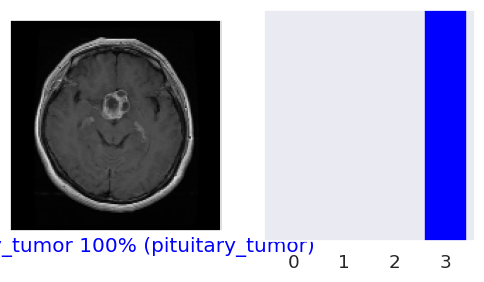

In [ ]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], y_test_num, X_test)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  y_test_num)
plt.show()

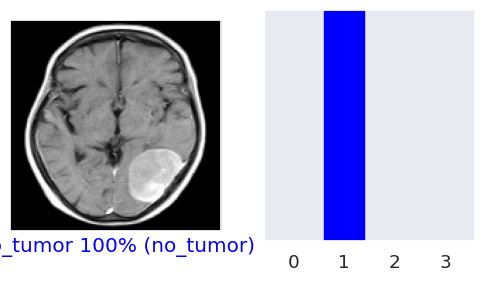

In [ ]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], y_test_num, X_test)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  y_test_num)
plt.show()

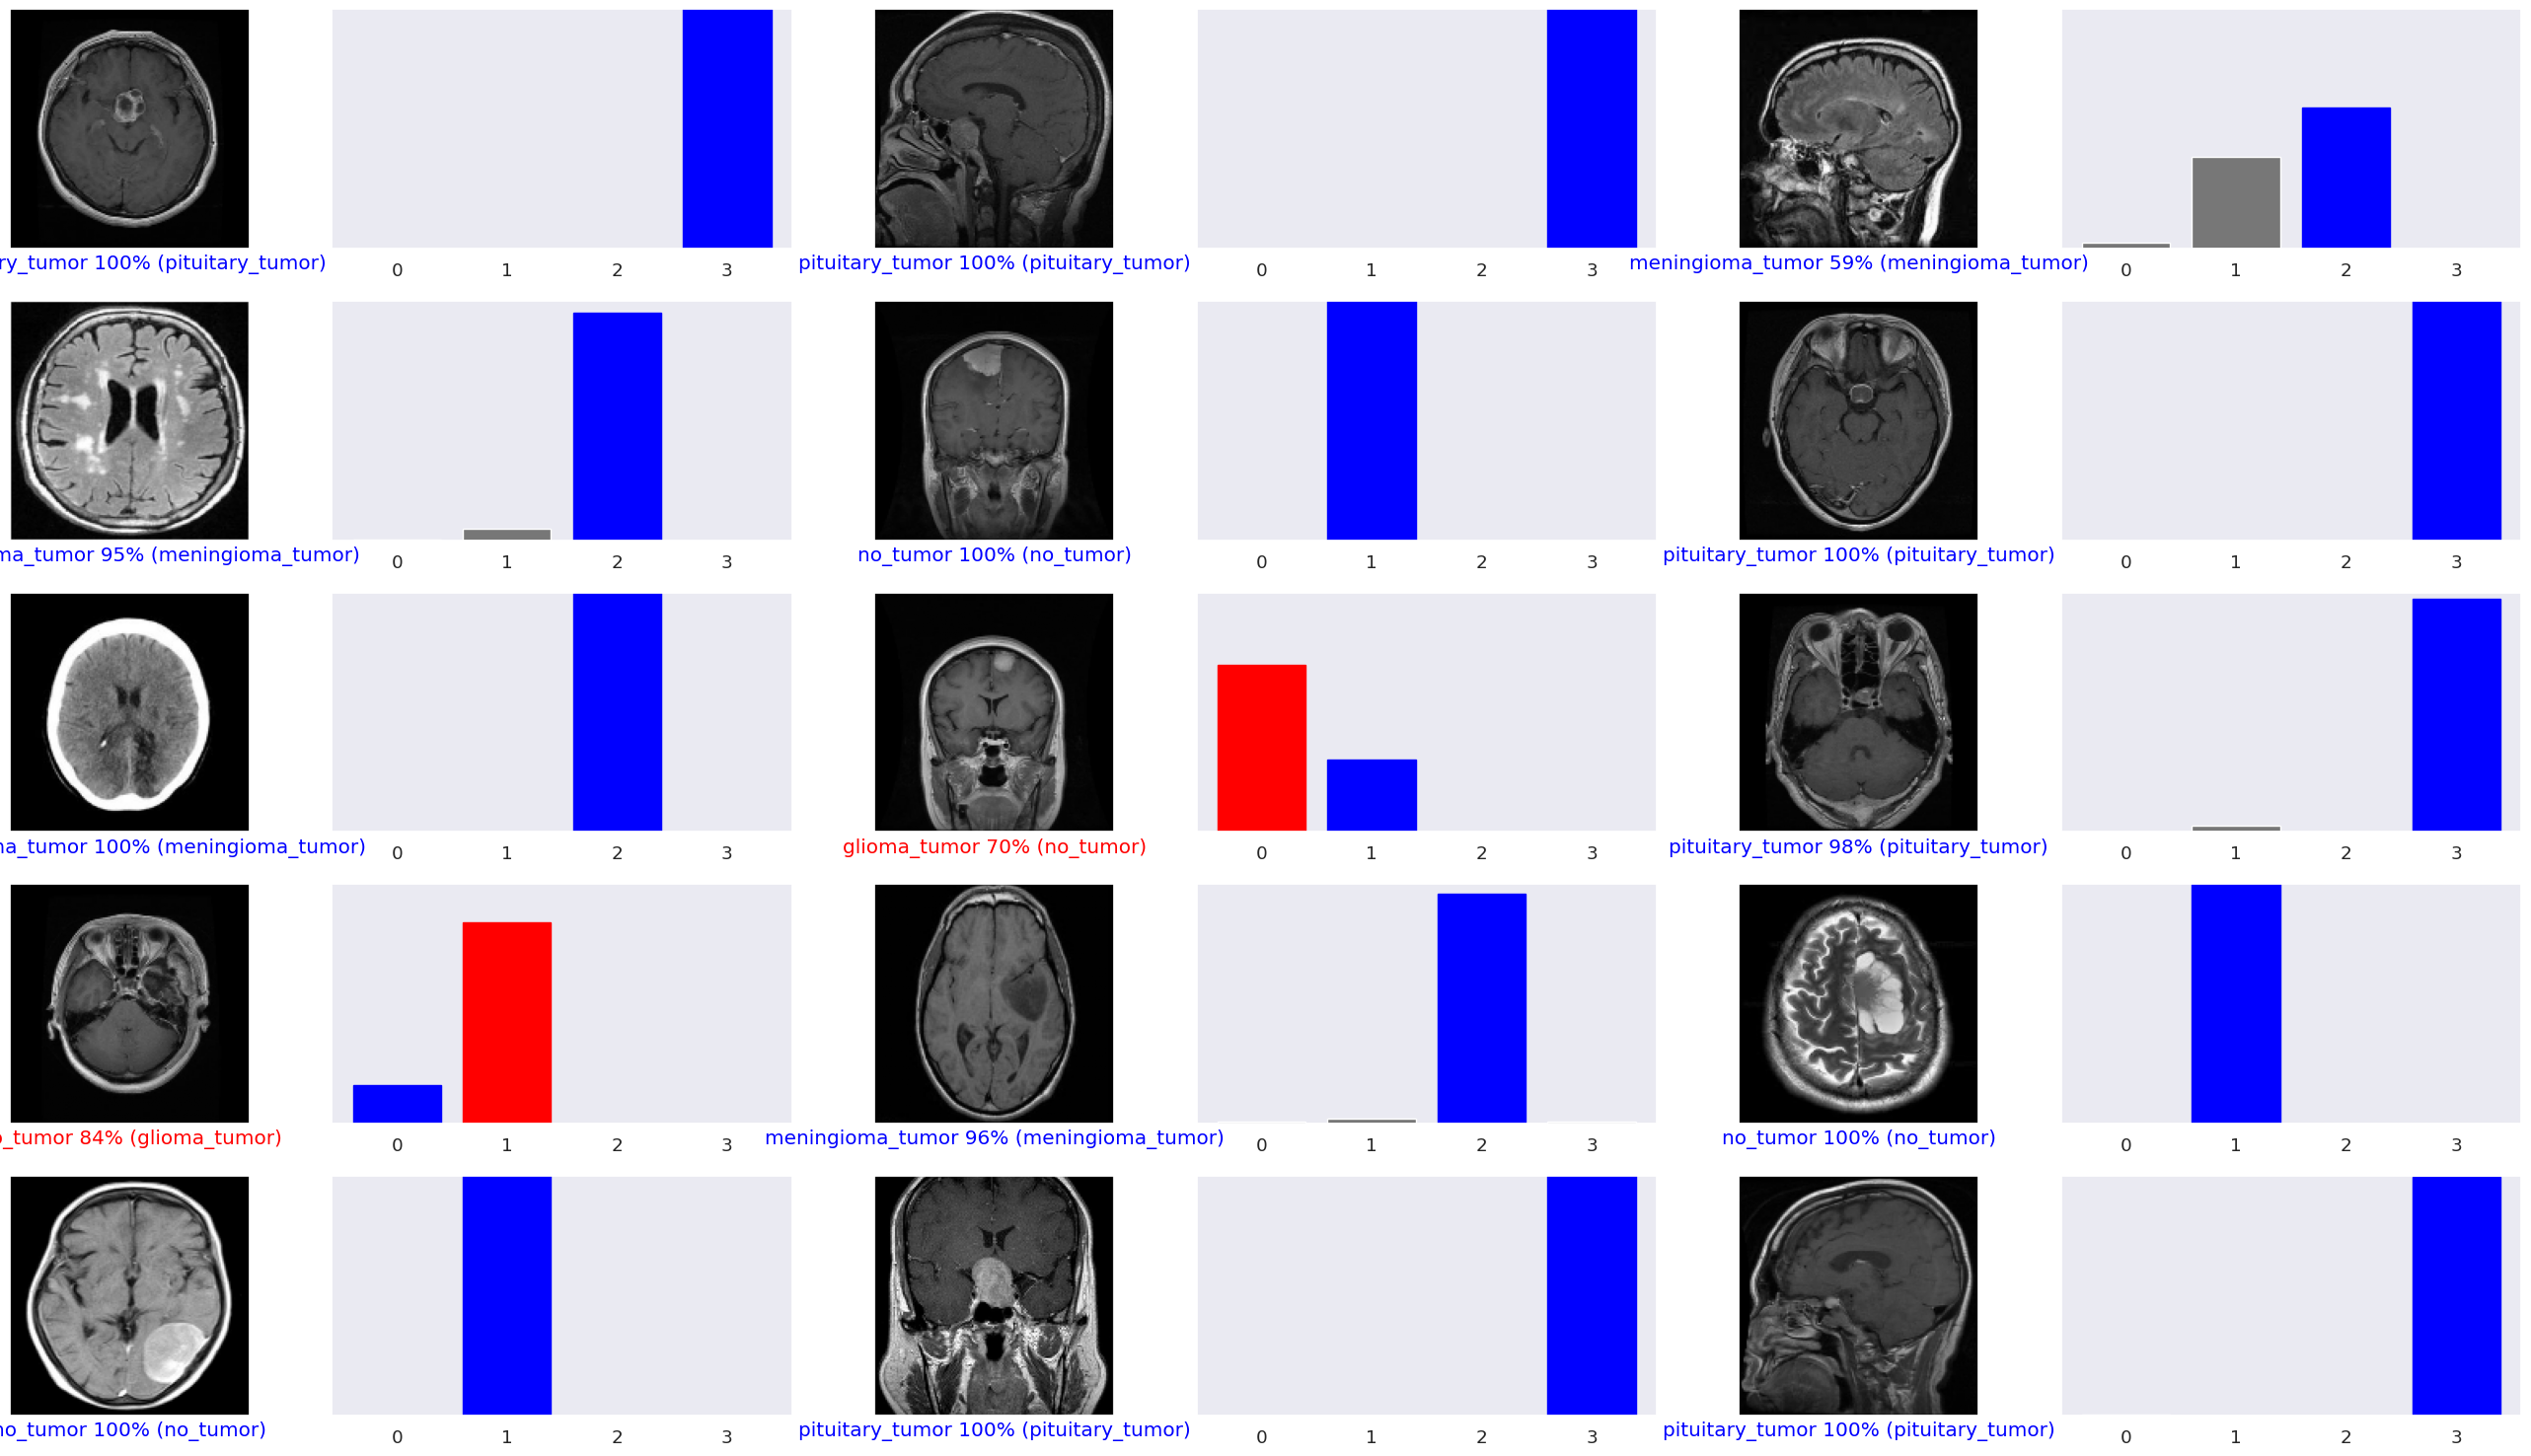

In [ ]:
num_rows = 5
num_cols = 3
num_images = num_rows * num_cols
plt.figure(figsize=(3*3*num_cols, 3*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, predictions[i], y_test_num, X_test)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions[i], y_test_num)
plt.tight_layout()
plt.show()


**Direktno predviđanje nad jednim podatkom**

In [ ]:
X_test.shape

(327, 150, 150, 3)

In [ ]:
uzorak = X_test[1]
print(uzorak.shape)

(150, 150, 3)


Koristi se funkcija np.expand_dims iz NumPy biblioteke kako bi se proširio oblik varijable uzorak. Pozivanjem np.expand_dims(uzorak,0), dodaje se nova dimenzija na početak oblika, što znači da će sada oblik biti (1, visina, širina, broj kanala). Ovo je potrebno jer modeli zahtijevaju ulaz u obliku batcha, a dodavanje dimenzije batcha omogućuje modelu da obradi samo jedan primjer u isto vrijeme.

In [ ]:
# Add the image to a batch where it's the only member.
uzorak = (np.expand_dims(uzorak,0))

print(uzorak.shape)

(1, 150, 150, 3)


Predikcija vjerojatnosti za jedan pojedinačni uzorak slike.

In [ ]:
predictions_single = probability_model.predict(uzorak)

print(predictions_single)

1/1 [==============================] - 1s 502ms/step
[[0.17487776 0.17487776 0.1748779  0.4753666 ]]


Vizualizacija vjerojatnosti predikcija za pojedinačni uzorak slike.

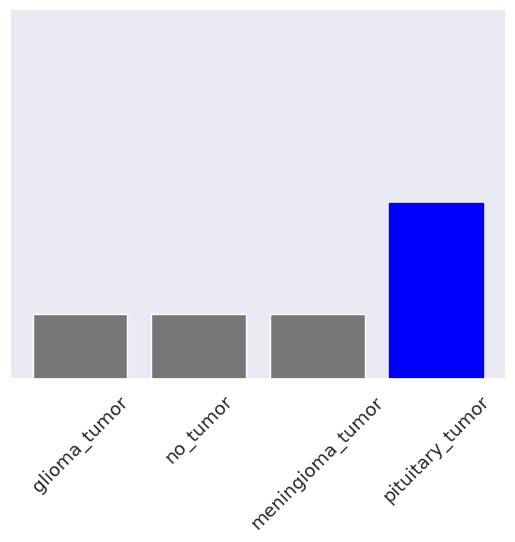

In [ ]:
plot_value_array(1, predictions_single[0], y_test_num)
_ = plt.xticks(range(4), labels, rotation=45)
plt.show()

Predviđena klasa.

In [ ]:
np.argmax(predictions_single[0])

3

**Pogledajmo primjere pogrešno razvrstanih slika**

Varijabla br_pogresnih se izračunava kao broj slika u testnom skupu pomnožen s postotkom netočnosti modela (1 - točnost modela). To se računa kako bi se odredio broj slika koje su pogrešno klasificirane.

In [ ]:
br_pogresnih = int((1-test_accuracy)*X_test.shape[0])
print('Pogrešno razvrstanih slika: {}/{}'.format(br_pogresnih, X_test.shape[0]))

Pogrešno razvrstanih slika: 48/327


In [ ]:
import random

Predviđanja modela na skupu za testiranje.

In [ ]:
y_hat = model.predict(X_test)

11/11 [==============================] - 0s 16ms/step


Iterira kroz predikcije (pred) i stvarne oznake (labela) za svaki par iz y_hat (predikcije modela) i y_test_num (stvarne oznake) koristeći funkciju zip.

Koristi se funkcija enumerate kako bi se generirali indeksi (i) i parovi (pred, labela) iz iterirane liste.

Za svaki par, provjerava se da li indeks najveće vrijednosti u predikciji (np.argmax(pred)) nije jednak stvarnoj oznaci (labela), što bi ukazivalo na pogrešnu predikciju.

Ako predikcija nije točna, tada se stvara tupl (i, np.argmax(pred), labela, y_hat[i]), gdje i predstavlja indeks slike, np.argmax(pred) predstavlja indeks najveće vrijednosti u predikciji, labela je stvarna oznaka slike, a y_hat[i] su vjerojatnosti predikcije za tu sliku.

Svi takvi tuplovi se dodaju u listu pogresni.

Na kraju, varijabla pogresni sadrži informacije o pogrešno klasificiranim slikama, uključujući njihove indekse, predikcije, stvarne oznake i vjerojatnosti predikcije.

In [ ]:
pogresni = [(i, np.argmax(pred), labela, y_hat[i]) for i, (pred, labela) in enumerate(zip(y_hat, y_test_num)) if np.argmax(pred) != labela]

Vizualizacija pogrešno klasificiranih slika zajedno s predikcijama i vjerojatnostima predikcija za svaku od klasa.

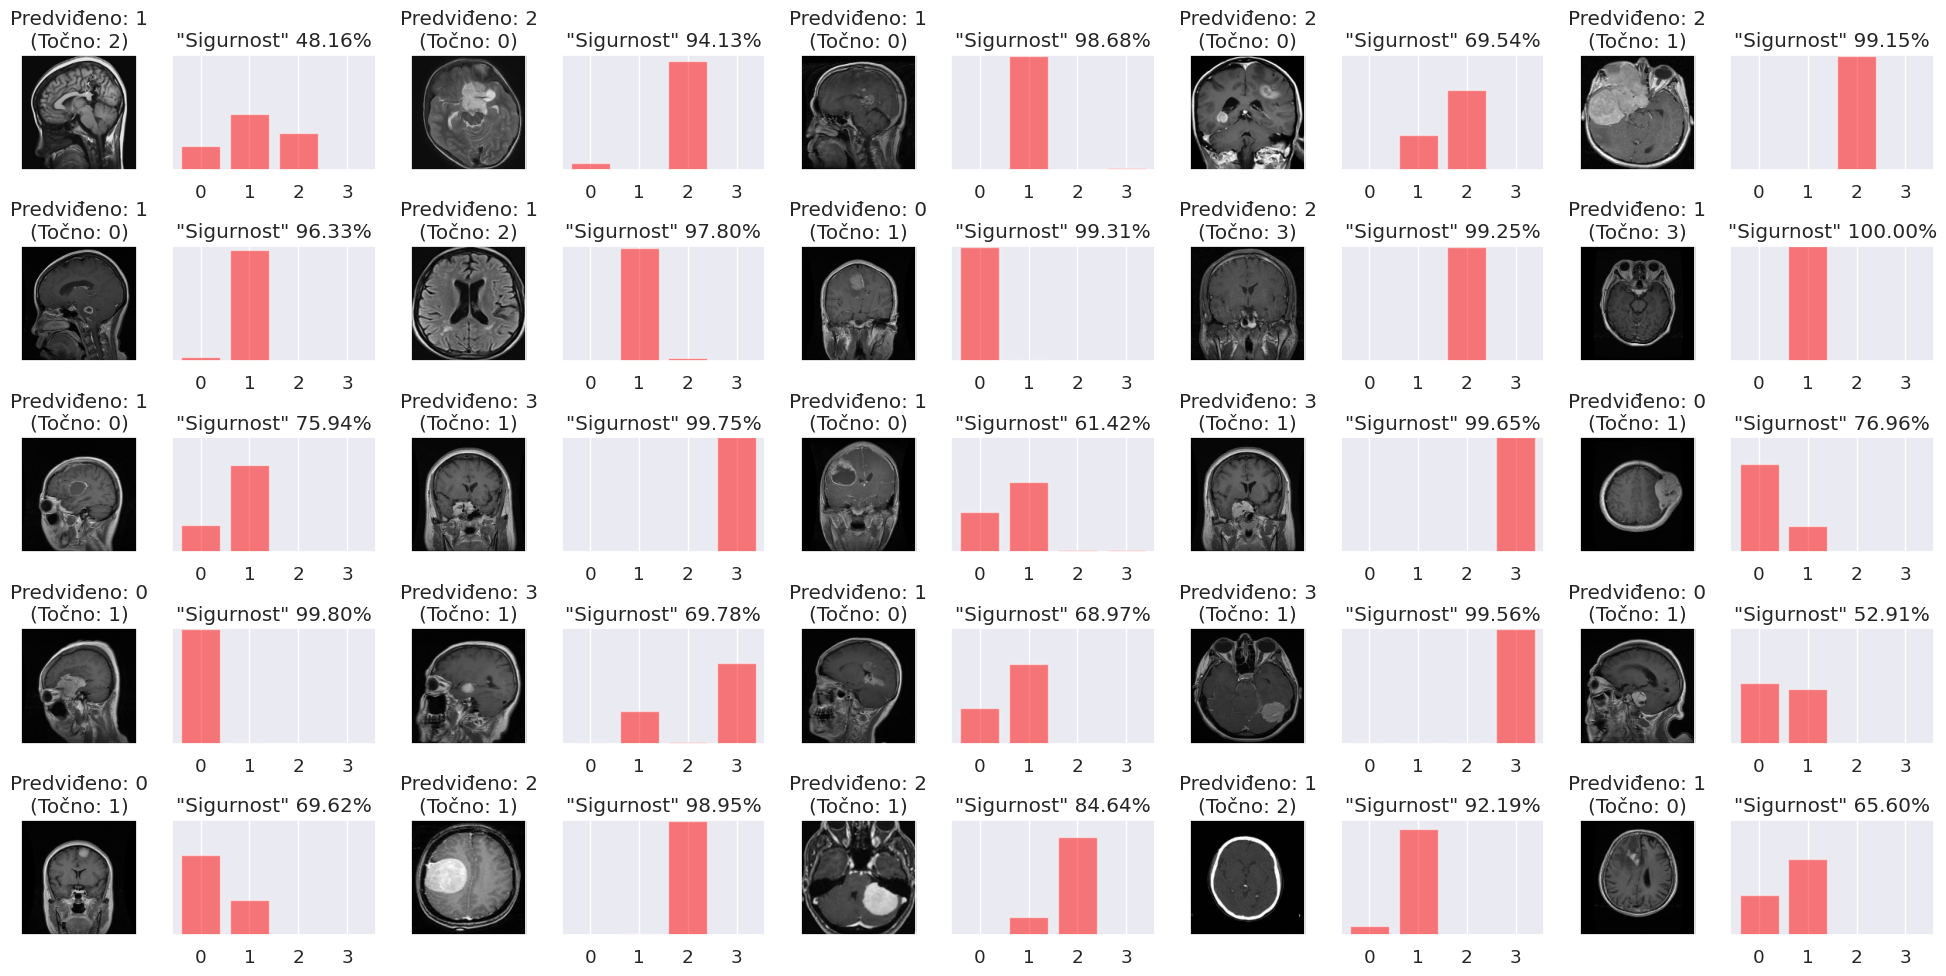

In [ ]:
fig = plt.figure(figsize=(20, 10))
num_classes = 4
xs = np.arange(num_classes)

cnt = 0

for i, pred, tocno, pred_vjerojatnosti in random.sample(pogresni, 25):
    cnt += 1
    ax1 = fig.add_subplot(5, 10, cnt)
    plt.title("Predviđeno: {}\n(Točno: {})".format(pred, tocno))
    plt.imshow(X_test[i].reshape(150, 150, 3))  # Prilagodi veličinu slike prema potrebi
    plt.xticks([]), plt.yticks([])

    cnt += 1
    ax2 = fig.add_subplot(5, 10, cnt)
    sigurnost = pred_vjerojatnosti[pred] * 100
    plt.title("\"Sigurnost\" {:.2f}%".format(sigurnost))
    plt.bar(xs, pred_vjerojatnosti, color="red", alpha=0.5)
    plt.xticks(xs), plt.yticks([])
    plt.ylim([0, 1])
    plt.tight_layout()

plt.show()


###Nadogradnja Modela 1 (1. pokušaj)

Dodan je još jedan konvolucijski sloj (Conv2D(256, (3, 3), activation='relu')) i povećan je broj jedinica u potpuno povezanom sloju (Dense(256, activation='relu')).


In [ ]:
model_1 = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu'),  # Dodan dodatni konvolucijski sloj
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),  # Povećan broj jedinica u potpuno povezanom sloju
    layers.Dense(128, activation='relu'),
    layers.Dense(4, activation='softmax')
])

model_1.compile(optimizer='adam',
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                metrics=['accuracy'])

# Treniranje modela
model_1.fit(X_train, y_train_onehot, epochs=10, validation_data=(X_test, y_test_onehot))

# Evaluacija modela na testnom skupu
test_loss, test_accuracy = model_1.evaluate(X_test, y_test_onehot, verbose=2)

print(f"\nTočnost na testnom skupu: {test_accuracy * 100:.2f}%")


Epoch 1/10
48/48 [==============================] - 6s 49ms/step - loss: 1.1855 - accuracy: 0.4522 - val_loss: 1.0875 - val_accuracy: 0.4924
Epoch 2/10
48/48 [==============================] - 2s 32ms/step - loss: 0.7791 - accuracy: 0.7048 - val_loss: 0.7311 - val_accuracy: 0.7156
Epoch 3/10
48/48 [==============================] - 2s 32ms/step - loss: 0.5412 - accuracy: 0.7886 - val_loss: 0.6506 - val_accuracy: 0.7584
Epoch 4/10
48/48 [==============================] - 2s 32ms/step - loss: 0.3855 - accuracy: 0.8645 - val_loss: 0.6175 - val_accuracy: 0.7951
Epoch 5/10
48/48 [==============================] - 2s 32ms/step - loss: 0.2798 - accuracy: 0.8979 - val_loss: 0.5462 - val_accuracy: 0.8226
Epoch 6/10
48/48 [==============================] - 2s 33ms/step - loss: 0.1997 - accuracy: 0.9267 - val_loss: 0.5773 - val_accuracy: 0.8073
Epoch 7/10
48/48 [==============================] - 2s 35ms/step - loss: 0.1286 - accuracy: 0.9496 - val_loss: 0.5834 - val_accuracy: 0.8349
Epoch 8/10
48

Veća točnost u odnosu na Model 1.

###Nadogradnja Modela 1 (2. pokušaj)

Dodala sam slojeve Dropout kako bi smanjila prenaučenost, a također koristim kernel_regularizer za primjenu L2 regularizacije na težinama potpuno povezanih slojeva. Također sam povećala broj epoha sa 10 na 15.

In [ ]:
from tensorflow.keras import regularizers

model_2 = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),  # Dodan kernel_regularizer
    layers.Dropout(0.5),  # Dodan dropout
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.5),  # Dodan dropout
    layers.Dense(4, activation='softmax')
])

model_2.compile(optimizer='adam',
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                metrics=['accuracy'])

# Treniranje modela
model_2.fit(X_train, y_train_onehot, epochs=15, validation_data=(X_test, y_test_onehot))

# Evaluacija modela na testnom skupu
test_loss, test_accuracy = model_2.evaluate(X_test, y_test_onehot, verbose=2)

print(f"\nTočnost na testnom skupu: {test_accuracy * 100:.2f}%")


Epoch 1/15
48/48 [==============================] - 6s 44ms/step - loss: 3.4828 - accuracy: 0.3024 - val_loss: 2.0265 - val_accuracy: 0.2722
Epoch 2/15
48/48 [==============================] - 2s 33ms/step - loss: 1.7600 - accuracy: 0.4450 - val_loss: 1.5075 - val_accuracy: 0.5229
Epoch 3/15
48/48 [==============================] - 2s 36ms/step - loss: 1.3402 - accuracy: 0.5949 - val_loss: 1.2283 - val_accuracy: 0.6391
Epoch 4/15
48/48 [==============================] - 2s 40ms/step - loss: 1.1904 - accuracy: 0.6387 - val_loss: 1.1342 - val_accuracy: 0.6453
Epoch 5/15
48/48 [==============================] - 2s 34ms/step - loss: 1.0679 - accuracy: 0.6944 - val_loss: 1.0290 - val_accuracy: 0.6942
Epoch 6/15
48/48 [==============================] - 2s 33ms/step - loss: 0.9337 - accuracy: 0.7317 - val_loss: 1.0653 - val_accuracy: 0.6942
Epoch 7/15
48/48 [==============================] - 2s 33ms/step - loss: 0.9378 - accuracy: 0.7520 - val_loss: 1.0329 - val_accuracy: 0.6881
Epoch 8/15
48

Veća točnost u odnosu na Model 1.

###Metode regularizacije nad Modelom 3

Uvodimo regularizaciju bi se spriječila prenaučenost (overfitting) modela. Glavni cilj regularizacije je smanjiti kompleksnost modela, sprječavajući ga da se prilagodi prekomjerno šumom ili specifičnostima trening skupa podataka koje možda nisu relevantne za općenite uzorke

**$L_2$ regularizacija**

*("weight decay")*


- $\lambda \in [0,+\infty \rangle$ **parametar regularizacije**

In [ ]:
lambda_l2 = 0.0005

Razlika u odnosu na Model 3:

Dodajemo L2 regularizaciju na težine svih konvolucijskih slojeva i potpuno povezanih slojeva, dok model osnovni_model ne primjenjuje nikakvu regularizaciju.

Parametar kernel_regularizer: U modelu s L2 regularizacijom, svaki konvolucijski i potpuno povezani sloj ima parametar kernel_regularizer=tf.keras.regularizers.l2(lambda_l2), gdje lambda_l2 predstavlja faktor regularizacije. Ovaj parametar kontrolira koliko snažno će se primjenjivati L2 regularizacija na težine tih slojeva.

Dodavanje L2 regularizacije može pomoći u kontroli prenaučenosti modela tako da dodaje kaznu za velike težine, sprječavajući ih da postanu prekomjerno velike. To može poboljšati sposobnost modela da generalizira na nove podatke.

In [ ]:
model_l2 = tf.keras.models.Sequential()

# 1. CONV blok
model_l2.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(150, 150, 3),
                                    kernel_regularizer=tf.keras.regularizers.l2(lambda_l2)))
model_l2.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same',
                                    kernel_regularizer=tf.keras.regularizers.l2(lambda_l2)))
model_l2.add(tf.keras.layers.MaxPool2D((2, 2)))

# 2. CONV blok
model_l2.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same',
                                    kernel_regularizer=tf.keras.regularizers.l2(lambda_l2)))
model_l2.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same',
                                    kernel_regularizer=tf.keras.regularizers.l2(lambda_l2)))
model_l2.add(tf.keras.layers.MaxPool2D((2, 2)))

# 3. CONV blok
model_l2.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same',
                                    kernel_regularizer=tf.keras.regularizers.l2(lambda_l2)))
model_l2.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same',
                                    kernel_regularizer=tf.keras.regularizers.l2(lambda_l2)))
model_l2.add(tf.keras.layers.MaxPool2D((2, 2)))


# 4. Klasifikacijska "glava"
model_l2.add(tf.keras.layers.Flatten())
model_l2.add(tf.keras.layers.Dense(128, activation='relu',
                                   kernel_regularizer=tf.keras.regularizers.l2(lambda_l2)))
model_l2.add(tf.keras.layers.Dense(4, activation='softmax'))



model_l2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
l2_hist = model_l2.fit(X_train, y_train_onehot, epochs=BR_EPOHA, batch_size=BATCH_SIZE, validation_split=0.2)

Epoch 1/50
20/20 [==============================] - 6s 159ms/step - loss: 1.6282 - accuracy: 0.3642 - val_loss: 1.6712 - val_accuracy: 0.2157
Epoch 2/50
20/20 [==============================] - 3s 127ms/step - loss: 1.3100 - accuracy: 0.5016 - val_loss: 2.0325 - val_accuracy: 0.3039
Epoch 3/50
20/20 [==============================] - 2s 123ms/step - loss: 1.0805 - accuracy: 0.5974 - val_loss: 1.4868 - val_accuracy: 0.4935
Epoch 4/50
20/20 [==============================] - 2s 120ms/step - loss: 0.9328 - accuracy: 0.6743 - val_loss: 0.7557 - val_accuracy: 0.7908
Epoch 5/50
20/20 [==============================] - 2s 120ms/step - loss: 0.8095 - accuracy: 0.7430 - val_loss: 0.6178 - val_accuracy: 0.8235
Epoch 6/50
20/20 [==============================] - 3s 127ms/step - loss: 0.7539 - accuracy: 0.7349 - val_loss: 0.9651 - val_accuracy: 0.6569
Epoch 7/50
20/20 [==============================] - 2s 124ms/step - loss: 0.6095 - accuracy: 0.8175 - val_loss: 0.5986 - val_accuracy: 0.7941
Epoch 

Vizualna usporedba gubitna i točnosti Modela 3 i Modela 3 s dodanom L2 regularizacijom.

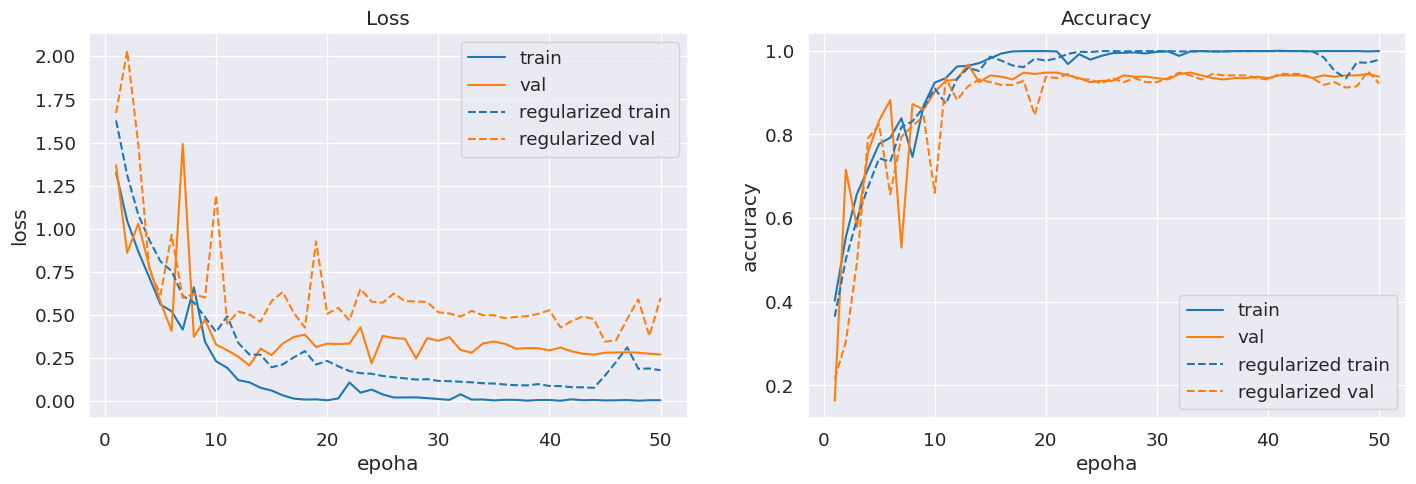

In [ ]:
plot_history(baseline_hist,l2_hist)

In [ ]:
print('Baseline:')
print_acc(model_baseline)
print('-'*50)
print('L2:')
print_acc(model_l2)

Baseline:
Accuracy (test data): 82.87 %
--------------------------------------------------
L2:
Accuracy (test data): 79.51 %


In [ ]:
from sklearn.metrics import precision_score

def print_precision(model, model_name):
    predictions = model.predict(X_test)
    y_pred = np.argmax(predictions, axis=1)  # Pretvori predikcije u indekse najvjerojatnijih klasa
    y_true = np.argmax(y_test_onehot, axis=1)  # Pretvori one-hot kodirane oznake u indekse klasa

    precision = precision_score(y_true, y_pred, average='weighted')

    print(f"Preciznost modela {model_name}: {precision * 100:.2f}%")

print_precision(model_baseline, "Baseline")
print("-" * 50)
print_precision(model_l2, "L2")


11/11 [==============================] - 0s 18ms/step
Preciznost modela Baseline: 82.86%
--------------------------------------------------
11/11 [==============================] - 0s 17ms/step
Preciznost modela L2: 79.73%


Sa L2 regularizacijom se smanjila točnost i preciznost.

**Probajmo vise različitih lambda**

In [ ]:
import tensorflow as tf

def create_model(lambda_l2):
    model = tf.keras.models.Sequential()

    # 1. CONV blok
    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(150, 150, 3),
                                    kernel_regularizer=tf.keras.regularizers.l2(lambda_l2)))
    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same',
                                    kernel_regularizer=tf.keras.regularizers.l2(lambda_l2)))
    model.add(tf.keras.layers.MaxPool2D((2, 2)))

    # 2. CONV blok
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same',
                                    kernel_regularizer=tf.keras.regularizers.l2(lambda_l2)))
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same',
                                    kernel_regularizer=tf.keras.regularizers.l2(lambda_l2)))
    model.add(tf.keras.layers.MaxPool2D((2, 2)))

    # 3. CONV blok
    model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same',
                                    kernel_regularizer=tf.keras.regularizers.l2(lambda_l2)))
    model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same',
                                    kernel_regularizer=tf.keras.regularizers.l2(lambda_l2)))
    model.add(tf.keras.layers.MaxPool2D((2, 2)))

    # 4. Klasifikacijska "glava"
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128, activation='relu',
                                   kernel_regularizer=tf.keras.regularizers.l2(lambda_l2)))
    model.add(tf.keras.layers.Dense(4, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
best_accuracy = 0
best_lambda = None

lambda_values = [0.0001, 0.0005, 0.001]

for lambda_l2 in lambda_values:
    model = create_model(lambda_l2)
    model.fit(X_train, y_train_onehot, epochs=10, batch_size=32, validation_data=(X_test, y_test_onehot))

    _, test_accuracy = model.evaluate(X_test, y_test_onehot, verbose=0)

    print(f"Lambda: {lambda_l2}, Test Accuracy: {test_accuracy}")

    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        best_lambda = lambda_l2

print(f"\nBest Lambda: {best_lambda}, Best Test Accuracy: {best_accuracy}")


Epoch 1/10
48/48 [==============================] - 12s 145ms/step - loss: 1.2595 - accuracy: 0.4882 - val_loss: 1.2307 - val_accuracy: 0.5352
Epoch 2/10
48/48 [==============================] - 3s 68ms/step - loss: 0.8934 - accuracy: 0.6512 - val_loss: 0.8711 - val_accuracy: 0.6575
Epoch 3/10
48/48 [==============================] - 3s 66ms/step - loss: 0.6308 - accuracy: 0.7762 - val_loss: 0.8425 - val_accuracy: 0.6972
Epoch 4/10
48/48 [==============================] - 3s 65ms/step - loss: 0.5059 - accuracy: 0.8298 - val_loss: 0.7655 - val_accuracy: 0.7584
Epoch 5/10
48/48 [==============================] - 3s 66ms/step - loss: 0.3746 - accuracy: 0.8848 - val_loss: 0.6432 - val_accuracy: 0.8012
Epoch 6/10
48/48 [==============================] - 3s 70ms/step - loss: 0.2779 - accuracy: 0.9202 - val_loss: 0.8396 - val_accuracy: 0.7798
Epoch 7/10
48/48 [==============================] - 3s 67ms/step - loss: 0.2428 - accuracy: 0.9365 - val_loss: 0.9363 - val_accuracy: 0.7064
Epoch 8/10


Najbolji lambda je 0.0001 , ali ni on nije povećao točnost Modela 3.

###**FC(Potpuno povezane neuronske mreže)**

Jednostavan model s potpuno povezanim slojevima (fully connected layers).

tf.keras.models.Sequential(): Stvara se instanca sekvencijalnog modela koji će sadržavati sve slojeve mreže.

 Prvi sloj je Flatten sloj, koji služi za ravnanje (flatten) ulaznih podataka. Ovaj sloj pretvara višedimenzionalne ulazne podatke (u ovom slučaju slike dimenzija 150x150x3) u jednodimenzionalni vektor. Ovdje se također postavlja oblik ulaznih podataka putem parametra input_shape.

Dodaje se potpuno povezani (dense) sloj s 64 neurona. Aktivacijska funkcija ovog sloja je ReLU (Rectified Linear Activation).

Dodaje se još jedan potpuno povezani sloj, ali ovaj put s 128 neurona i aktivacijskom funkcijom ReLU.

Dodaje se još jedan potpuno povezani sloj, ovaj put s 64 neurona i aktivacijskom funkcijom ReLU.

Dodaje se još jedan potpuno povezani sloj, ovaj put s 32 neurona i aktivacijskom funkcijom ReLU.

Završni potpuno povezani sloj ima 4 neurona, što odgovara broju klasa u klasifikaciji. Aktivacijska funkcija ovog sloja je softmax, koja pretvara izlaze neurona u vjerojatnosti pripadnosti svakoj od klasa.

Kompilacija modela. Postavlja se funkcija gubitka (loss function) na sparse categorical crossentropy, što je prikladno za probleme klasifikacije s više klasa. Optimizator je Adam, a metrika koja se koristi za praćenje performansi modela je točnost (accuracy).








In [ ]:
model_FC = tf.keras.models.Sequential()
model_FC.add(tf.keras.layers.Flatten(input_shape=(150, 150, 3)))
model_FC.add(tf.keras.layers.Dense(64, activation='relu'))
model_FC.add(tf.keras.layers.Dense(128, activation='relu'))
model_FC.add(tf.keras.layers.Dense(64, activation='relu'))
model_FC.add(tf.keras.layers.Dense(32, activation='relu'))
model_FC.add(tf.keras.layers.Dense(4, activation='softmax'))  # Promijeni na 4 ako imaš 4 klase

model_FC.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [ ]:
model_FC.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_7 (Flatten)         (None, 67500)             0         
                                                                 
 dense_16 (Dense)            (None, 64)                4320064   
                                                                 
 dense_17 (Dense)            (None, 128)               8320      
                                                                 
 dense_18 (Dense)            (None, 64)                8256      
                                                                 
 dense_19 (Dense)            (None, 32)                2080      
                                                                 
 dense_20 (Dense)            (None, 4)                 132       
                                                                 
Total params: 4338852 (16.55 MB)
Trainable params: 433

Sparse_categorical_crossentropy automatski radi konverziju numeričkih oznaka klasa u one-hot vektore, zato radimo sa y_train_num.

In [ ]:
povijest_FC = model_FC.fit(X_train, y_train_num, epochs=10, batch_size=64, validation_split=0.2)

Epoch 1/10
20/20 [==============================] - 3s 54ms/step - loss: 1.9419 - accuracy: 0.3011 - val_loss: 1.8531 - val_accuracy: 0.1438
Epoch 2/10
20/20 [==============================] - 1s 31ms/step - loss: 1.2385 - accuracy: 0.4534 - val_loss: 1.7674 - val_accuracy: 0.4804
Epoch 3/10
20/20 [==============================] - 1s 29ms/step - loss: 1.1204 - accuracy: 0.5172 - val_loss: 2.2300 - val_accuracy: 0.1797
Epoch 4/10
20/20 [==============================] - 1s 28ms/step - loss: 1.0491 - accuracy: 0.5376 - val_loss: 0.8947 - val_accuracy: 0.7320
Epoch 5/10
20/20 [==============================] - 1s 26ms/step - loss: 0.9098 - accuracy: 0.6097 - val_loss: 0.7189 - val_accuracy: 0.7549
Epoch 6/10
20/20 [==============================] - 1s 29ms/step - loss: 0.8725 - accuracy: 0.6334 - val_loss: 2.2121 - val_accuracy: 0.2745
Epoch 7/10
20/20 [==============================] - 1s 29ms/step - loss: 0.8597 - accuracy: 0.6260 - val_loss: 0.7885 - val_accuracy: 0.6765
Epoch 8/10
20

In [ ]:
_, test_acc = model_FC.evaluate(X_test, y_test_num, verbose=0)
print("Tocnost na skupu za testiranje: {:.2f}%".format(test_acc*100))

Tocnost na skupu za testiranje: 67.28%


In [ ]:
def plot_history(hist_baseline, br_epoha, hist_FC=None):

    fig = plt.figure(figsize = (17,5))
    metrics = ["loss", "accuracy"]

    for i in range(len(metrics)):
        metric = metrics[i]
        plt.subplot(1, 2, i+1)
        plt.title(metric.capitalize())
        plt.xlabel("epoha")
        plt.ylabel(metric)
        plt.plot(range(1, br_epoha + 1), hist_baseline.history[metric],
                 label="train CNN", color="tab:blue")
        plt.plot(range(1, br_epoha + 1), hist_baseline.history["val_" + metric],
                 label="val CNN", color="tab:orange")

        if hist_FC:
            plt.plot(range(1, br_epoha + 1), hist_FC.history[metric],
                 label="train FC", color="tab:blue", linestyle='--', alpha=0.5)
            plt.plot(range(1, br_epoha + 1), hist_FC.history["val_" + metric],
                 label="val FC", color="tab:orange", linestyle='--', alpha=0.5)
        plt.legend()

10 je br epoha

Vizualna usporedba sa Modelom 1

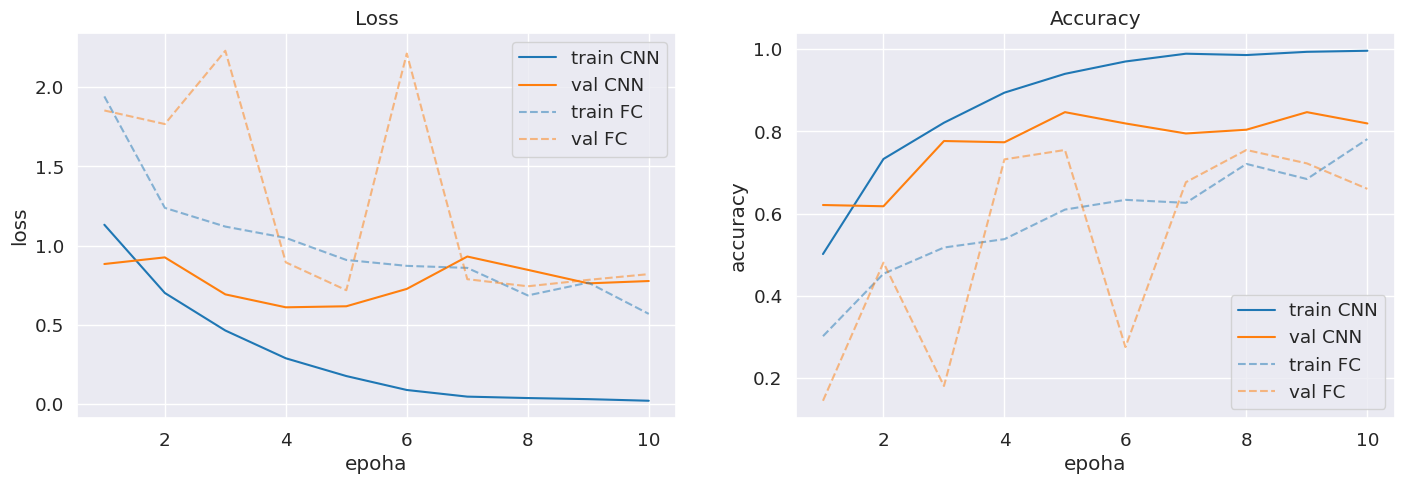

In [ ]:
plot_history(povijest, 10, povijest_FC)

**ZAKLJUČAK USPOREDBA CNN I FN:** <br>Korištenje konvolucijskih neuronskih mreža (CNN) umjesto potpuno povezanih neuronskih mreža (FC) za obradu slika često dovodi do boljih rezultata iz nekoliko razloga:

Ekstrakcija značajki: CNN-ovi su dizajnirani da automatski izvlače značajke iz slika. Konvolucijski slojevi koriste lokalne filtere kako bi detektirali različite uzorke poput rubova, oblika i tekstura. Ovaj proces ekstrakcije značajki omogućava modelu da automatski nauči relevantne informacije iz slika.

Podrška za lokalnost i translacijsku invarijantnost: Konvolucijski slojevi dijele težine, što znači da se isti filteri primjenjuju na različite dijelove slike. To čini mrežu invarijantnom na translacije, što je važno za prepoznavanje objekata bez obzira na njihov položaj u slici.

Smanjenje dimenzionalnosti: Slojevi za agregaciju poput slojeva maksimalnog usklađivanja smanjuju prostornu dimenzionalnost, čime se smanjuje broj parametara u mreži i povećava računska efikasnost.

Bolja generalizacija: CNN-ovi obično imaju manje parametara od potpuno povezanih mreža, što može dovesti do bolje generalizacije na nove, neviđene podatke.

### **Data augmentation / Povećanje podataka**


> Originalni skup podataka za treniranje se umjetno povećava primjenom različitih transforamcija na ulazne podatke
> - *paziti da se primjenom određene transformacije ne promijeni točna labela klase*

horizontal_flip = True: Omogućava horizontalno zrcaljenje slike. To znači da će se slike slučajno zrcaliti horizontalno tijekom treninga.

width_shift_range = 0.15: Omogućava slučajno pomicanje slike po širini. Vrijednost 0.15 znači da se slika može horizontalno pomaknuti za najviše 15% širine slike u lijevo ili desno.

height_shift_range = 0.15: Omogućava slučajno pomicanje slike po visini. Vrijednost 0.15 znači da se slika može vertikalno pomaknuti za najviše 15% visine slike prema gore ili prema dolje.

zoom_range = 0.1: Omogućava slučajno zumiranje slike. Vrijednost 0.1 znači da se slika može slučajno zumirati za najviše 10%.

rotation_range = 25: Omogućava slučajnu rotaciju slike za najviše 25 stupnjeva u smjeru suprotnom od kazaljke na satu ili u smjeru kazaljke na satu.

Sve ove transformacije pomažu povećati raznolikost podataka tijekom treninga, što može poboljšati sposobnost modela da generalizira na nove podatke i smanji prenaučenost.

In [ ]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    horizontal_flip = True,
    width_shift_range = 0.15,
    height_shift_range = 0.15,
    zoom_range = 0.1,
    rotation_range = 25)

Dohvaćamo sliku iz skupa za treniranje.

In [ ]:
img = X_train[7]

Vizualizacija.

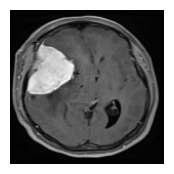

In [ ]:
plt.figure(figsize=(2, 2))
plt.imshow(img)
plt.axis('off')
plt.show()

Proširenje dimenzije slike.

In [ ]:
img = np.expand_dims(img, axis=0)
print(img.shape)

(1, 150, 150, 3)


Prikaz 16 augmentiranih verzija ulazne slike img koristeći postavke definirane u ImageDataGenerator objektu datagen. Ovo omogućava vizualizaciju različitih transformacija koje se primjenjuju na ulaznu sliku tijekom augmentacije podataka.

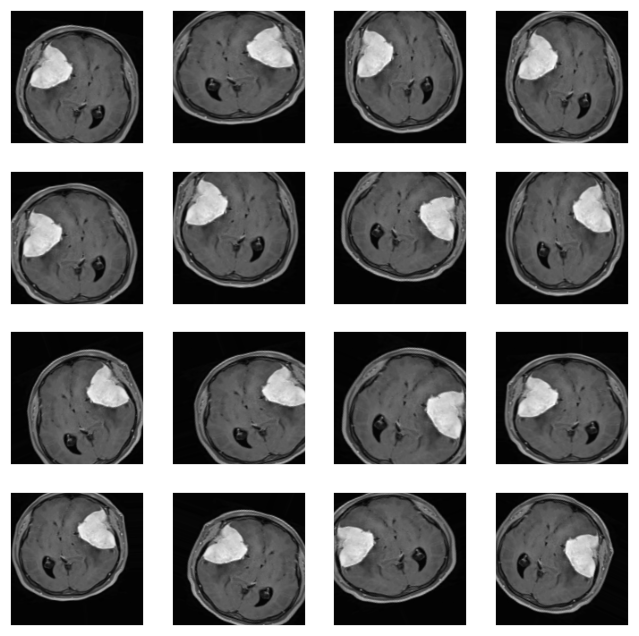

In [ ]:
flow_img = datagen.flow(img, batch_size=1)
fig = plt.figure(figsize=(8, 8))
for i in range(16):
    batch = next(flow_img)
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(batch[0])

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

Brojimo pojavljivanja svake jedinstvene vrijednosti u prvih 40 000 elemenata niza y_train_num.

In [ ]:
Counter(y_train_num[:40000])

Counter({0: 382, 1: 382, 3: 382, 2: 382})

Ovaj kod dijeli skup za treniranje (X_train i y_train_onehot) na dva podskupa: podskup za treniranje (X_train_data i y_train_data) i podskup za provjeru (X_valid_data i y_valid_data).(za validaciju 20%)

In [ ]:
split_index = int(0.8 * X_train.shape[0])

X_train_data = X_train[:split_index, :, :, :]
X_valid_data = X_train[split_index:, :, :, :]
y_train_data = y_train_onehot[:split_index]
y_valid_data = y_train_onehot[split_index:]

Koristimo ImageDataGenerator objekt datagen za generiranje augmentiranih slika i pripadajućih oznaka iz podataka za treniranje X_train_data i y_train_data.

Metoda flow() se koristi za generiranje augmentiranih slika i njihovih oznaka u obliku batcheva. Ovdje se koriste podaci za treniranje X_train_data i y_train_data kao ulazni podaci.

Train_flow predstavlja generirani tok podataka koji sadrži augmentirane slike i odgovarajuće oznake.

Omogućava dinamičko generiranje augmentiranih podataka tijekom treninga.

In [ ]:
train_flow = datagen.flow(X_train_data, y_train_data, batch_size=BATCH_SIZE)

Koristim osnovni model (osnovni_model()) kako bi se inicijalizirao model nazvan model_DA.

Argument verbose=1 označava da će se tijekom treniranja ispisivati informacije o tijeku treniranja, poput gubitka i metrika, za svaku epohu.

In [ ]:
model_DA = osnovni_model()
model_DA_history = model_DA.fit(
    train_flow,
    epochs=BR_EPOHA,
    verbose=1,
    validation_data=(X_valid_data, y_valid_data))

Epoch 1/50
20/20 [==============================] - 13s 441ms/step - loss: 1.3695 - accuracy: 0.3232 - val_loss: 1.6651 - val_accuracy: 0.1242
Epoch 2/50
20/20 [==============================] - 9s 470ms/step - loss: 1.3299 - accuracy: 0.3314 - val_loss: 1.4769 - val_accuracy: 0.1993
Epoch 3/50
20/20 [==============================] - 7s 359ms/step - loss: 1.2596 - accuracy: 0.4133 - val_loss: 1.4787 - val_accuracy: 0.2092
Epoch 4/50
20/20 [==============================] - 9s 475ms/step - loss: 1.2060 - accuracy: 0.4362 - val_loss: 1.3917 - val_accuracy: 0.1765
Epoch 5/50
20/20 [==============================] - 8s 372ms/step - loss: 1.1406 - accuracy: 0.4795 - val_loss: 1.2924 - val_accuracy: 0.2255
Epoch 6/50
20/20 [==============================] - 10s 491ms/step - loss: 1.0989 - accuracy: 0.5221 - val_loss: 1.1175 - val_accuracy: 0.6307
Epoch 7/50
20/20 [==============================] - 8s 393ms/step - loss: 1.1322 - accuracy: 0.5074 - val_loss: 1.2027 - val_accuracy: 0.5131
Epoc

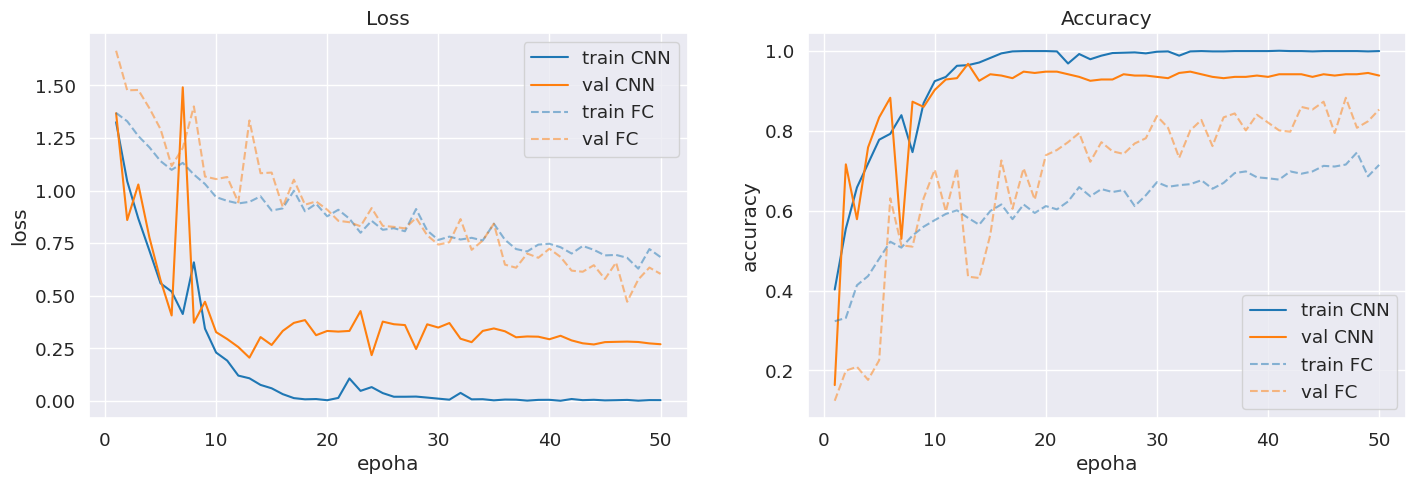

In [ ]:
plot_history(baseline_hist,50,model_DA_history)

In [ ]:
print('Baseline:')
print_acc(model_baseline)
print('-'*50)
print('Data Augmentation:')
print_acc(model_DA)

Baseline:
Accuracy (test data): 82.87 %
--------------------------------------------------
Data Augmentation:
Accuracy (test data): 70.34 %


Povećanjem podataka se smanjila točnost.

### **Dropout**

Za vrijeme treniranja na slučajan način ispuštamo neurone (s nekom unaprijed zadanom vjerojatnošću)
kako bi se spriječila njihova pretjerana koadaptacija koja dovodi do prenaučenosti modela.

<img src='https://miro.medium.com/max/1200/1*iWQzxhVlvadk6VAJjsgXgg.png' alt='Dropout' width='60%'>

Postotak neurona koji će biti isključeni tijekom treninga. Ova vrijednost određuje koliko će se neurona deaktivirati (postaviti na nulu) u svakom sloju tijekom svake epohe treninga.

In [ ]:
drop_rate = 0.3

Razlika u odnosu na Model 3 :  slojevi Dropout su dodani između svaka dva sloja konvolucije i prije zadnjeg sloja gusto povezanog (Dense) sloja.

In [ ]:
model_drop = tf.keras.models.Sequential()

# 1. CONV blok
model_drop.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(150, 150, 3)))
model_drop.add(tf.keras.layers.Dropout(drop_rate))
model_drop.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
model_drop.add(tf.keras.layers.Dropout(drop_rate))
model_drop.add(tf.keras.layers.MaxPool2D((2, 2)))

# 2. CONV blok
model_drop.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model_drop.add(tf.keras.layers.Dropout(drop_rate))
model_drop.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model_drop.add(tf.keras.layers.Dropout(drop_rate))
model_drop.add(tf.keras.layers.MaxPool2D((2, 2)))

# 3. CONV blok
model_drop.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model_drop.add(tf.keras.layers.Dropout(drop_rate))
model_drop.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model_drop.add(tf.keras.layers.Dropout(drop_rate))
model_drop.add(tf.keras.layers.MaxPool2D((2, 2)))

# 4. klasifikacijska "glava"
model_drop.add(tf.keras.layers.Flatten())
model_drop.add(tf.keras.layers.Dense(128, activation='relu'))
model_drop.add(tf.keras.layers.Dropout(drop_rate))
model_drop.add(tf.keras.layers.Dense(4, activation='softmax'))

model_drop.compile(optimizer='adam',
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

In [ ]:
drop_hist = model_drop.fit(X_train, y_train_onehot, epochs=BR_EPOHA, batch_size=BATCH_SIZE, validation_split=0.2)

Epoch 1/50
20/20 [==============================] - 7s 226ms/step - loss: 1.5580 - accuracy: 0.3314 - val_loss: 1.3963 - val_accuracy: 0.1536
Epoch 2/50
20/20 [==============================] - 4s 183ms/step - loss: 1.2729 - accuracy: 0.4403 - val_loss: 1.4198 - val_accuracy: 0.2124
Epoch 3/50
20/20 [==============================] - 4s 179ms/step - loss: 1.1212 - accuracy: 0.5155 - val_loss: 1.3760 - val_accuracy: 0.2843
Epoch 4/50
20/20 [==============================] - 4s 179ms/step - loss: 1.0119 - accuracy: 0.5753 - val_loss: 1.4513 - val_accuracy: 0.1895
Epoch 5/50
20/20 [==============================] - 4s 183ms/step - loss: 0.8921 - accuracy: 0.6350 - val_loss: 1.5171 - val_accuracy: 0.2124
Epoch 6/50
20/20 [==============================] - 4s 190ms/step - loss: 0.7821 - accuracy: 0.6759 - val_loss: 1.3995 - val_accuracy: 0.3497
Epoch 7/50
20/20 [==============================] - 4s 179ms/step - loss: 0.7292 - accuracy: 0.7005 - val_loss: 1.4063 - val_accuracy: 0.3497
Epoch 

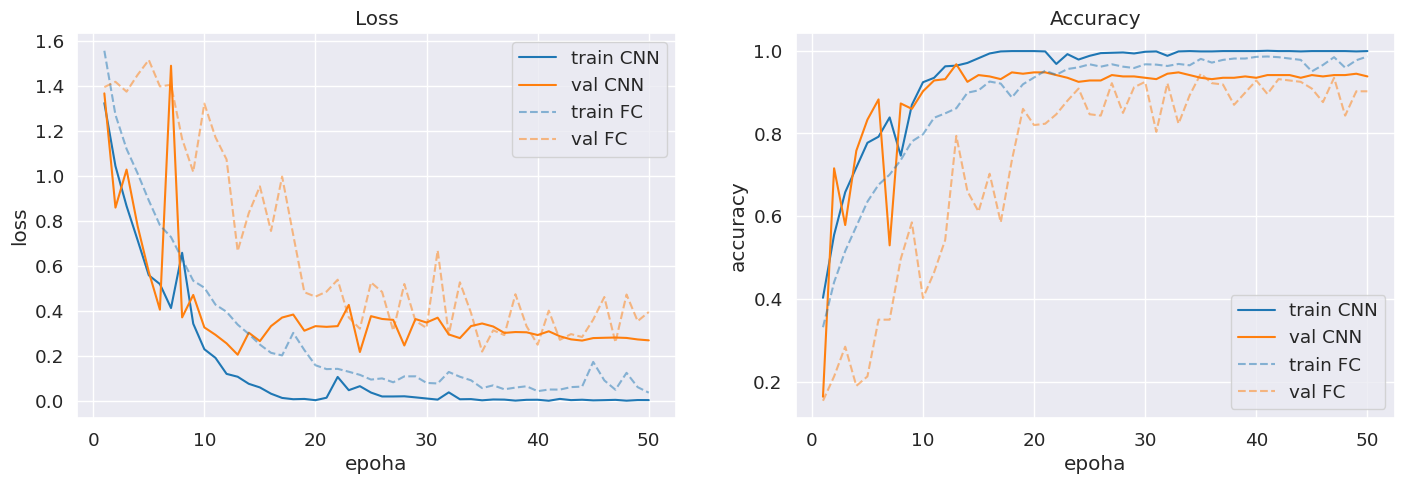

In [ ]:
plot_history(baseline_hist,50,drop_hist)

In [ ]:
print('Baseline:')
print_acc(model_baseline)
print('-'*50)
print('Dropout:')
print_acc(model_drop)

Baseline:
Accuracy (test data): 82.87 %
--------------------------------------------------
Dropout:
Accuracy (test data): 75.84 %


Sa dropoutom se smanjila točnost.

###  **Rano zaustavljanje (engl. *early stopping*)**


> Metoda regularizacije koja zaustavlja proces treniranja neuronske mreže prije nastupanja prenaučenosti

<img src="https://drive.google.com/uc?id=1vhRKiyw2rbiOwkGKnOMCM8mh8Bmd3TkG" alt=early_stop.png width=600px>


Koristimo EarlyStopping povratni poziv (callback) kako bi se zaustavilo treniranje mreže ako gubitak na skupu za validaciju ne poboljšava tijekom 3 uzastope epohe.

Značenje pojedinih argumenata:

monitor='val_loss': Ovdje se prati gubitak na skupu za validaciju. EarlyStopping će pratiti ovu metriku i zaustaviti treniranje ako se gubitak na skupu za validaciju ne poboljšava.

patience=3: Ovo označava broj uzastopnih epoha bez poboljšanja gubitka na skupu za validaciju prije nego što se treniranje zaustavi. U ovom slučaju, ako gubitak na skupu za validaciju ne poboljšava tijekom 3 uzastopne epohe, treniranje će se zaustaviti.

restore_best_weights=True: Kada se treniranje zaustavi, ova opcija omogućuje vraćanje težina modela na one koje su bile najbolje (najmanji gubitak na skupu za validaciju) tijekom treniranja. Ovo je korisno jer osigurava da model zadrži najbolje naučene težine prije zaustavljanja treniranja.

Povratni poziv EarlyStopping se zatim koristi kao argument u fit metodi modela (callbacks=[callback_ES]), što omogućuje Kerasu da koristi ovaj povratni poziv tijekom treniranja kako bi provjerio uvjete zaustavljanja i prekinuo treniranje ako su zadovoljeni.

In [ ]:
# zaustavljamo treniranje mreže ako 3 uzastopne epohe nema poboljšanja gubitka na skupu za validaciju
callback_ES = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

model_ES = osnovni_model()
hist_es = model_ES.fit(X_train, y_train_onehot, epochs=BR_EPOHA, batch_size=BATCH_SIZE, validation_split=0.2,
                       callbacks=[callback_ES])

Epoch 1/50
20/20 [==============================] - 5s 151ms/step - loss: 1.2925 - accuracy: 0.3887 - val_loss: 1.3712 - val_accuracy: 0.2908
Epoch 2/50
20/20 [==============================] - 2s 123ms/step - loss: 1.0053 - accuracy: 0.5745 - val_loss: 1.1213 - val_accuracy: 0.4869
Epoch 3/50
20/20 [==============================] - 3s 129ms/step - loss: 0.8125 - accuracy: 0.6424 - val_loss: 0.7165 - val_accuracy: 0.7614
Epoch 4/50
20/20 [==============================] - 2s 123ms/step - loss: 0.6879 - accuracy: 0.7038 - val_loss: 0.4925 - val_accuracy: 0.8464
Epoch 5/50
20/20 [==============================] - 2s 122ms/step - loss: 0.5696 - accuracy: 0.7799 - val_loss: 0.8965 - val_accuracy: 0.6765
Epoch 6/50
20/20 [==============================] - 2s 123ms/step - loss: 0.4385 - accuracy: 0.8306 - val_loss: 0.2886 - val_accuracy: 0.9183
Epoch 7/50
20/20 [==============================] - 2s 123ms/step - loss: 0.3525 - accuracy: 0.8715 - val_loss: 0.4673 - val_accuracy: 0.8660
Epoch 

In [ ]:
print("Model se zaustavio nakon {} epoha".format(callback_ES.stopped_epoch))

Model se zaustavio nakon 10 epoha


Vizualna usporedba Modela 3 i Modela 3 sa ranim zaustavljanjem (uspoređujemo samo one epohe koje je moguće usporediti tj uzimamo manji broj epoha).

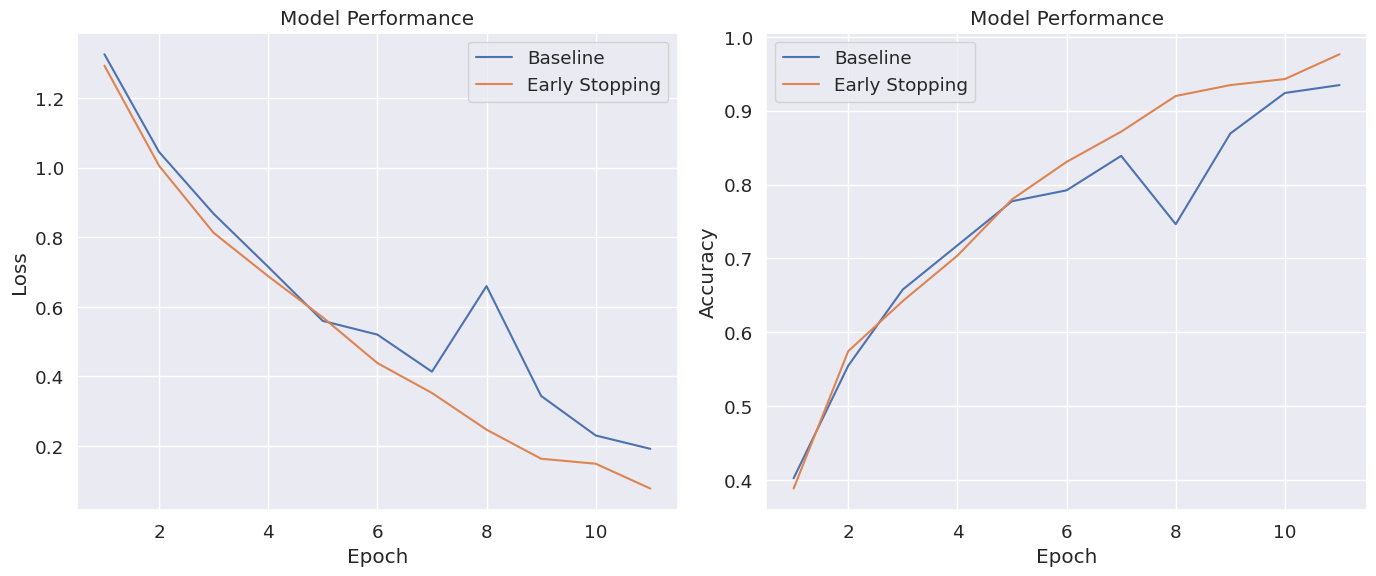

In [ ]:
def plot_history(hist_baseline, hist_early_stopping):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

    min_epochs = min(len(hist_baseline.history['loss']), len(hist_early_stopping.history['loss']))

    for ax, metric in zip(axes, ['loss', 'accuracy']):
        ax.plot(range(1, min_epochs + 1), hist_baseline.history[metric][:min_epochs], label='Baseline')
        ax.plot(range(1, min_epochs + 1), hist_early_stopping.history[metric][:min_epochs], label='Early Stopping')
        ax.set_xlabel('Epoch')
        ax.set_ylabel(metric.capitalize())
        ax.set_title('Model Performance')
        ax.legend()

    plt.tight_layout()
    plt.show()

# Pozivanje funkcije za crtanje grafova
plot_history(baseline_hist, hist_es)


In [ ]:
print('Baseline:')
print_acc(model_baseline)
print('-'*50)
print('Early Stopping:')
print_acc(model_ES)

Baseline:
Accuracy (test data): 82.87 %
--------------------------------------------------
Early Stopping:
Accuracy (test data): 83.49 %


Sa ranim zaustavljanjem se smanjila točnost.

###**Implementacija (jednostavnog) autoenkodera**


Enkoder: Prvi dio autoenkodera naziva se enkoder. To je neuronska mreža koja prima ulazne podatke i mapira ih u prostor manje dimenzije, nazvan latentni prostor. Enkoder pokušava naučiti komprimirati ulazne podatke u značajniju reprezentaciju.

Latentni prostor: Latentni prostor predstavlja skriveni prostor u kojem se reprezentiraju ulazni podaci. Dimenzija latentnog prostora određuje se pri izradi autoenkodera i predstavlja broj varijabli ili dimenzija koje će se koristiti za reprezentaciju podataka. Manja dimenzija latentnog prostora znači da će se podaci komprimirati u manji prostor, dok veća dimenzija znači da će reprezentacija biti složenija.

Dekoder: Nakon što su podaci komprimirani u latentnom prostoru, dolazi drugi dio autoenkodera nazvan dekoder. Dekoder je također neuronska mreža koja prima reprezentaciju podataka iz latentnog prostora i pokušava rekonstruirati originalne ulazne podatke. Cilj je naučiti dekoder da što vjernije rekonstruira ulazne podatke iz latentne reprezentacije.

Funkcija gubitka: Za obuku autoenkodera koristi se funkcija gubitka koja mjeri razliku između ulaznih podataka i njihovih rekonstruiranih verzija. Cilj je minimizirati ovu razliku tijekom procesa obuke kako bi se osiguralo da autoenkoder dobro nauči reprezentirati podatke u latentnom prostoru.

> Umjesto da kažemo da se radi o **nenadziranom** učenju, preciznije bi bilo reći da se radi o **samonadziranom** učenju.

Obuhvaća stvaranje neuronske mreže koja se sastoji od dva glavna dijela: enkoder i dekoder.

Autoenkoder se koristi za učenje reprezentacije podataka tako da se ulazni podaci prvo smanje na kompaktni skriveni prostor (enkoder), a zatim se rekonstruiraju natrag u izvorne podatke (dekoder).

Autoenkoderi su vrsta neuronskih mreža koje uče efikasno kodirati ulazne podatke u kompaktnu reprezentaciju, nazvanu latentni prostor, i zatim ih rekonstruirati iz te reprezentacije.

Autoenkoderi pokušavaju naučiti predstaviti ulazne podatke na najbolji mogući način koristeći što manje resursa.

Latentni prostor, ili latentni dimenzionalni prostor, je skup svih mogućih reprezentacija podataka koje se koriste za opisivanje određenih značajki ili karakteristika ulaznih podataka. U kontekstu autoenkodera, latentni prostor je skriveni sloj ili slojevi u modelu koji služe za reprezentaciju ulaznih podataka.

 Ideja je naučiti reprezentaciju podataka koja sadrži bitne značajke ulaznih podataka, tako da se može koristiti za rekonstrukciju originalnih podataka ili za generiranje novih sličnih podataka.



Dimenzija mojih podataka tj svakog od 1634 uzoraka je 150 X 150 X 3.

In [ ]:
X.shape

(1634, 150, 150, 3)

In [ ]:
latent_dim = 64

Za kodiranje i dekodiranje slika.

Ulazni sloj: Input sloj definira ulazne podatke u obliku slika dimenzija (150, 150, 3). shape=(150, 150, 3) specificira oblik ulaznih slika.

Koder: Nakon ulaznog sloja, slika se "ravnopravi" pomoću sloja Flatten, što znači da se višedimenzionalna slika pretvara u jednodimenzionalni vektor. Ovaj vektor se zatim prolazi kroz sloj Dense koji ima latent_dim=64 neurona i aktivacijsku funkciju relu. Rezultat ovog sloja je latentna reprezentacija slike, koja se često naziva "kodom".

Dekoder: Nakon što je slika zakodirana, dolazi do procesa dekodiranja. Ulaz u dekoder je latentna reprezentacija slike. Dekoder se sastoji od sloja Dense koji ima 150 * 150 * 3 neurona, što odgovara veličini slike prije nego što je bila ravnana. Aktivacijska funkcija ovog sloja je sigmoid, što rezultira izlazom koji je u rasponu između 0 i 1, što je tipično za slike. Nakon toga, sloj Reshape ponovno oblikuje izlaz u oblik slike dimenzija (150, 150, 3).

Kompilacija modela: Konačno, model se kompilira pomoću optimizatora 'adam' i funkcije gubitka 'mse' (Mean Squared Error), što je uobičajeni izbor za zadatke rekonstrukcije slika.

Povratna vrijednost:Funkcija vraća model autoenkodera.

In [ ]:
def Autoencoder(latent_dim):
    # model ćemo definirati koristeći FUNKCIONALNI API
    # KODER
    input_img = tf.keras.layers.Input(shape=(150, 150, 3), name='INPUT')  # ulazna slika
    flatten_img = tf.keras.layers.Flatten()(input_img)
    code = tf.keras.layers.Dense(latent_dim, activation='relu', name='CODE')(flatten_img)  # latentna reprezentacija slike (KOD)

    # DEKODER
    decoded_img = tf.keras.layers.Dense(150 * 150 * 3, activation='sigmoid')(code)
    decoded_img = tf.keras.layers.Reshape((150, 150, 3), name='OUTPUT')(decoded_img)  # rekonstruirana slika

    autoencoder = tf.keras.models.Model(input_img, decoded_img)
    autoencoder.compile(optimizer='adam', loss='mse')

    return autoencoder

In [ ]:
autoencoder = Autoencoder(latent_dim)

In [ ]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 INPUT (InputLayer)          [(None, 150, 150, 3)]     0         
                                                                 
 flatten_11 (Flatten)        (None, 67500)             0         
                                                                 
 CODE (Dense)                (None, 64)                4320064   
                                                                 
 dense_27 (Dense)            (None, 67500)             4387500   
                                                                 
 OUTPUT (Reshape)            (None, 150, 150, 3)       0         
                                                                 
Total params: 8707564 (33.22 MB)
Trainable params: 8707564 (33.22 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


X_train su ulazni i ciljni podaci (jer autoenkoderi pokušavaju rekonstruirati ulazne podatke te minimizirati razliku između rekonstrukcije i originalnih ulaznih podataka).

In [ ]:
autoencoder.fit(X_train, X_train,
                epochs=10,
                batch_size=128,
                validation_data=(X_test, X_test))

Epoch 1/10
12/12 [==============================] - 4s 186ms/step - loss: 0.0809 - val_loss: 0.0410
Epoch 2/10
12/12 [==============================] - 1s 110ms/step - loss: 0.0407 - val_loss: 0.0339
Epoch 3/10
12/12 [==============================] - 1s 113ms/step - loss: 0.0338 - val_loss: 0.0297
Epoch 4/10
12/12 [==============================] - 1s 68ms/step - loss: 0.0308 - val_loss: 0.0280
Epoch 5/10
12/12 [==============================] - 1s 72ms/step - loss: 0.0292 - val_loss: 0.0271
Epoch 6/10
12/12 [==============================] - 1s 71ms/step - loss: 0.0280 - val_loss: 0.0268
Epoch 7/10
12/12 [==============================] - 1s 70ms/step - loss: 0.0270 - val_loss: 0.0258
Epoch 8/10
12/12 [==============================] - 1s 70ms/step - loss: 0.0260 - val_loss: 0.0251
Epoch 9/10
12/12 [==============================] - 1s 68ms/step - loss: 0.0252 - val_loss: 0.0257
Epoch 10/10
12/12 [==============================] - 1s 57ms/step - loss: 0.0246 - val_loss: 0.0243


Prikaz originalnih ulaznih slika, rekonstruiranih slike i razlika između njih za nekoliko primjera.

1/1 [==============================] - 0s 64ms/step


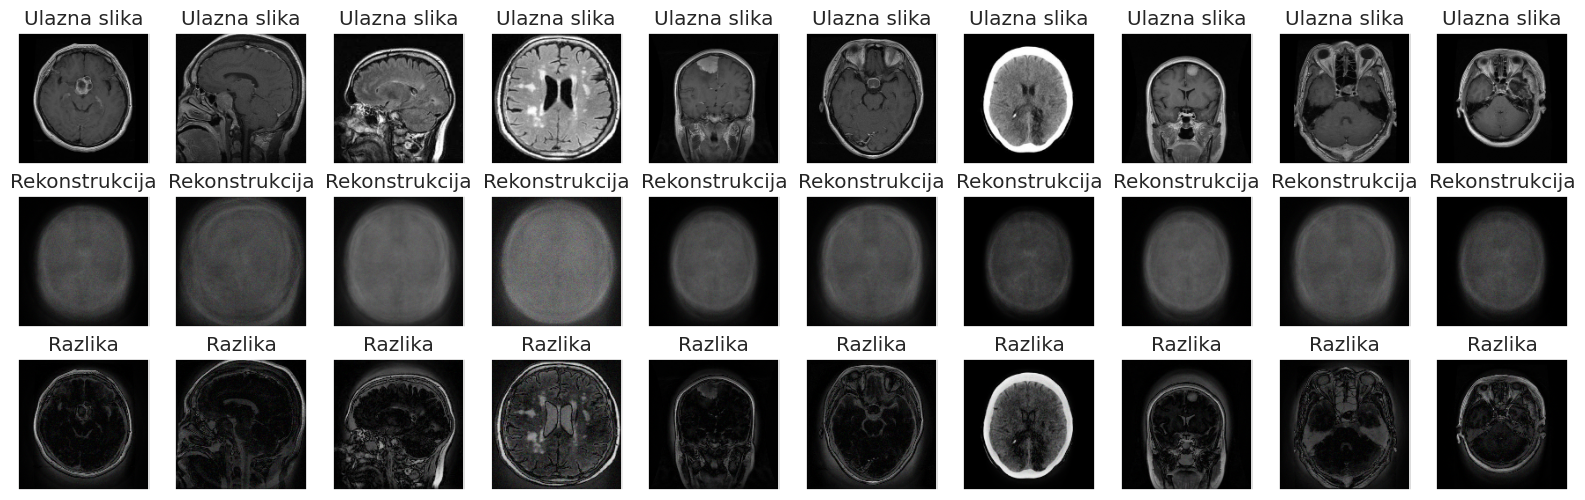

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_n_images(input_images, decoded_imgs, n=10, figsize=(20, 6)):
    plt.figure(figsize=figsize)

    for i in range(n):
        # ulaz autoenkodera
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(input_images[i])
        plt.title('Ulazna slika')
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # rekonstrukcije
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(decoded_imgs[i])
        plt.title('Rekonstrukcija')
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # razlika između ulaza i rekonstrukcije
        ax = plt.subplot(3, n, i + 1 + 2 * n)
        difference = np.abs(input_images[i] - decoded_imgs[i])
        plt.imshow(difference)
        plt.title('Razlika')
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

# Primjer korištenja:
# Zamijenite X_test s vašim stvarnim podacima
input_images = X_test[:10]
decoded_images = autoencoder.predict(input_images)

plot_n_images(input_images, decoded_images)


###**Konvolucijski autoenkoder**

Ulazni sloj:

input_img definira ulazni sloj slike dimenzija (150, 150, 3)

Prvi konvolucijski sloj (Conv2D) ima 16 filtera veličine (3, 3), koristi ReLU aktivacijsku funkciju i istu veličinu i korak (padding='same') kako bi zadržao dimenzije ulaza.

Drugi konvolucijski sloj ima 8 filtera veličine (3, 3), također koristi ReLU aktivacijsku funkciju i koristi isti način popunjavanja.
Sloj ima ime 'CODE' jer predstavlja kodiranu reprezentaciju slike.

Dekodirajući slojevi:

Prvi sloj dekodiranja je dekonvolucijski sloj (Conv2DTranspose) s 8 filtera, veličinom (3, 3), aktivacijskom funkcijom ReLU i istim načinom popunjavanja.

Drugi sloj dekodiranja je također dekonvolucijski sloj s 16 filtera, veličinom (3, 3), ReLU aktivacijskom funkcijom i istim načinom popunjavanja.

Poboljšanje dimenzija slike:

Nakon dekonvolucije, slika se dobiva u originalnim dimenzijama, ali kako bi se osiguralo da rezultat odgovara originalnoj dimenziji slike (150x150x3), koristi se konvolucijski sloj s linearnom aktivacijskom funkcijom (sigmoid) i istim načinom popunjavanja kako bi se osiguralo da dimenzije izlaza odgovaraju originalnoj slici.

Također, koristi se Resizing sloj kako bi se poboljšale dimenzije slike na 150x150x3.

Kompilacija modela:

Model se kompilira koristeći Adam optimizator i srednjekvadratnu pogrešku (mse) kao funkciju gubitka.

Povratna vrijednost:

Funkcija vraća model autoenkodera.

In [ ]:
import tensorflow as tf

def ConvAE():
    input_img = tf.keras.layers.Input(shape=(150, 150, 3), name='INPUT')
    x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2)(input_img)
    x = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2, name='CODE')(x)

    # Dekodiranje
    x = tf.keras.layers.Conv2DTranspose(8, (3, 3), activation='relu', padding='same', strides=2)(x)
    x = tf.keras.layers.Conv2DTranspose(16, (3, 3), activation='relu', padding='same', strides=2)(x)

    # Poboljšanje dimenzija slike
    decoded_img = tf.keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same', name='OUTPUT')(x)
    decoded_img = tf.keras.layers.experimental.preprocessing.Resizing(150, 150)(decoded_img)  # Poboljšanje dimenzija

    model = tf.keras.models.Model(input_img, decoded_img)
    model.compile(optimizer='adam', loss='mse')
    return model


In [ ]:
conv_ae = ConvAE()
conv_ae.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 INPUT (InputLayer)          [(None, 150, 150, 3)]     0         
                                                                 
 conv2d_56 (Conv2D)          (None, 75, 75, 16)        448       
                                                                 
 CODE (Conv2D)               (None, 38, 38, 8)         1160      
                                                                 
 conv2d_transpose (Conv2DTr  (None, 76, 76, 8)         584       
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 152, 152, 16)      1168      
 Transpose)                                                      
                                                                 
 OUTPUT (Conv2D)             (None, 152, 152, 3)       435 

In [ ]:
conv_ae.fit(X_train, X_train,
            epochs=10,
            batch_size=128,
            validation_data=(X_test, X_test))

Epoch 1/10
12/12 [==============================] - 11s 483ms/step - loss: 0.1334 - val_loss: 0.1302
Epoch 2/10
12/12 [==============================] - 1s 116ms/step - loss: 0.1243 - val_loss: 0.1154
Epoch 3/10
12/12 [==============================] - 1s 121ms/step - loss: 0.1044 - val_loss: 0.0887
Epoch 4/10
12/12 [==============================] - 2s 131ms/step - loss: 0.0820 - val_loss: 0.0645
Epoch 5/10
12/12 [==============================] - 2s 160ms/step - loss: 0.0548 - val_loss: 0.0374
Epoch 6/10
12/12 [==============================] - 2s 160ms/step - loss: 0.0317 - val_loss: 0.0219
Epoch 7/10
12/12 [==============================] - 1s 116ms/step - loss: 0.0201 - val_loss: 0.0152
Epoch 8/10
12/12 [==============================] - 1s 121ms/step - loss: 0.0147 - val_loss: 0.0114
Epoch 9/10
12/12 [==============================] - 2s 127ms/step - loss: 0.0110 - val_loss: 0.0090
Epoch 10/10
12/12 [==============================] - 1s 120ms/step - loss: 0.0089 - val_loss: 0.007

Reconstr_imgs sadrži rekonstruirane slike generirane modelom konvolucijskog autoenkodera na temelju ulaznih podataka X_test.

In [ ]:
reconstr_imgs = conv_ae.predict(X_test)

11/11 [==============================] - 1s 30ms/step


Prikaz originalnih ulaznih slika, rekonstruiranih slike i razlika između njih za nekoliko primjera.

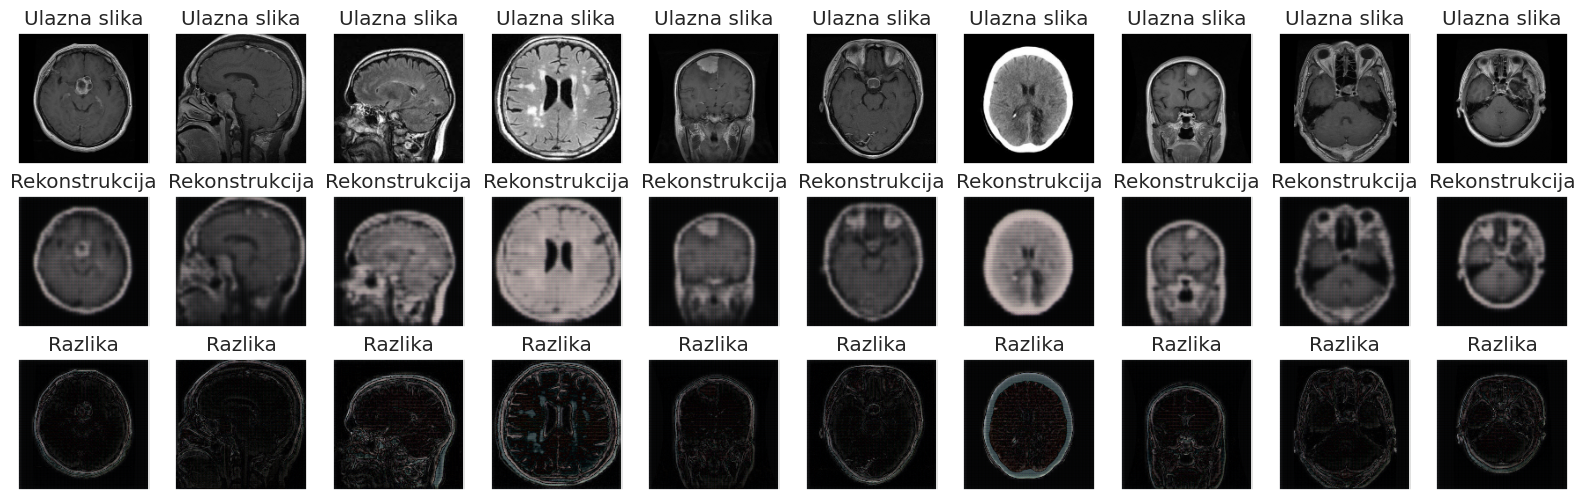

In [ ]:
plot_n_images(X_test, reconstr_imgs)

#**KNN**

##Usporedba korištenja različito kodiranih y (broj najbližih susjeda koje će algoritam uzeti u obzir prilikom klasifikacije=5)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics


Sa y numeričkim:

In [ ]:
# Inicijalizacija k-NN klasifikatora
knn = KNeighborsClassifier(n_neighbors=5)

# Treniranje modela
knn.fit(X_train_izravnan, y_train_num)

# Predikcija na skupu za testiranje
y_pred = knn.predict(X_test_izravnan)

# Evaluacija modela
accuracy = metrics.accuracy_score(y_test_num, y_pred)
print("Točnost: {:.2f}%".format(accuracy * 100))

Točnost: 72.17%


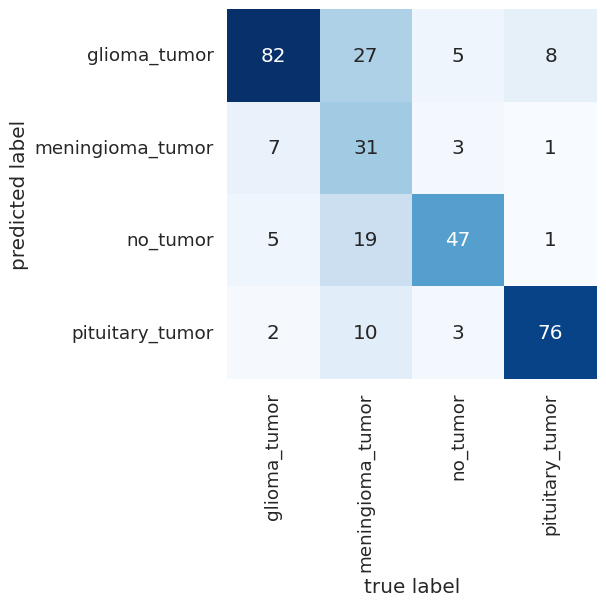

In [ ]:
values = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

mat = metrics.confusion_matrix(y_test_num, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=values, yticklabels=values,
            cmap='Blues')

plt.xlabel('true label')
plt.ylabel('predicted label');

Sa y onehot:

In [ ]:
# Inicijalizacija k-NN klasifikatora
knn = KNeighborsClassifier(n_neighbors=5)

# Treniranje modela
knn.fit(X_train_izravnan, y_train_onehot)

# Predikcija na skupu za testiranje
y_pred = knn.predict(X_test_izravnan)

# Evaluacija modela
accuracy = metrics.accuracy_score(y_test_onehot, y_pred)
print("Točnost: {:.2f}%".format(accuracy * 100))

Točnost: 68.20%


Veća je točnost kada smo koristili numerički kodiran y.

##Najbolja vrijednost za k

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
param_grid = {'n_neighbors': range(1, 10)}
knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=5)
grid_search.fit(X_train_izravnan, y_train_num)
print("Najbolja vrijednost za k:", grid_search.best_params_)

Najbolja vrijednost za k: {'n_neighbors': 1}


In [ ]:
# Inicijalizacija k-NN klasifikatora
knn = KNeighborsClassifier(n_neighbors=1)

# Treniranje modela
knn.fit(X_train_izravnan, y_train_num)

# Predikcija na skupu za testiranje
y_pred = knn.predict(X_test_izravnan)

# Evaluacija modela
accuracy = metrics.accuracy_score(y_test_num, y_pred)
print("Točnost: {:.2f}%".format(accuracy * 100))

Točnost: 80.12%


#**kMeans**

##Elbow metoda za najbolji k

Promatramo kako dodavanje nove grupe smanjuje sumu kvadrata udaljenosti (SSD) podataka od centara. Odabiremo  k  takav da se njegovim povećavanjem SSD neznatno smanji, a njegovim smanjivanje pogreška se znatno poveća.

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
ssd = []
ks = range(1, 10)
for k in ks:
  k_model = KMeans(n_clusters=k, n_init='auto')
  k_model.fit(X_izravnan)
  ssd.append(k_model.inertia_) # inercija: suma kvadrata udaljenosti podataka do najbližeg centra (centra nakupine kojoj podatak pripada)

print(ssd)

[2912169.0410659304, 2530300.895450092, 2362942.6548381485, 2296166.7839264893, 2244470.0138722793, 2212902.390086596, 2169974.731033382, 2146166.1923203617, 2118870.25122873]


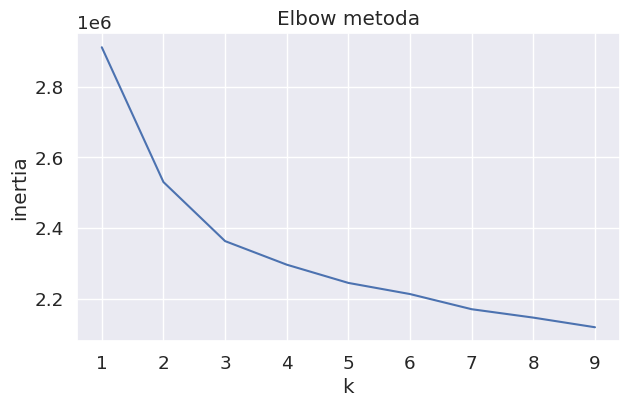

In [ ]:
plt.figure(figsize=(7,4))
plt.plot(ks, ssd)
plt.xlabel('k')
plt.ylabel('inertia')
plt.title('Elbow metoda')
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=2, n_init='auto')
kmeans.fit(X_izravnan)

KMeans(n_clusters=2, n_init='auto')

In [ ]:
centers = kmeans.cluster_centers_
print(f'CENTRI:\n{centers}')

CENTRI:
[[0.00563616 0.00563616 0.00563616 ... 0.00523458 0.00523458 0.00523458]
 [0.04265377 0.04265377 0.04265377 ... 0.04450328 0.04450328 0.04450328]]


In [ ]:
y_kmeans = kmeans.predict(X_izravnan) # za svaku točku odredi "najbližu" grupu kojoj pripada
print(y_kmeans[:15])
## alterantivno za točke koje su korištene u fit
# kmeans.labels_


[0 0 0 1 0 0 0 0 1 0 0 0 0 1 0]


Prikaz grupiranja tj projekcije na prve 2 koordinate

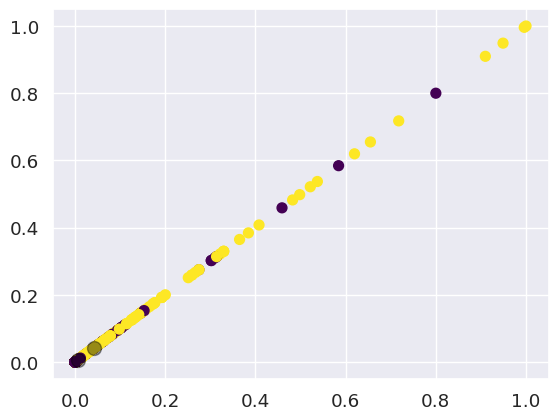

In [ ]:
plt.scatter(X_izravnan[:, 0], X_izravnan[:, 1], c=y_kmeans, s=50, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=100, alpha=0.4);

Kvaliteta grupiranja (što bliže 1 to bolje)

In [ ]:
from sklearn.metrics import silhouette_score
silhouette_avg = silhouette_score(X_izravnan, y_kmeans)
print("Silhouette Score:", silhouette_avg)

Silhouette Score: 0.1838223192780329
